# Install and Import

## Install

In [ ]:
!pip install einops

!git clone https://github.com/VainF/DeepLabV3Plus-Pytorch
!cp -r DeepLabV3Plus-Pytorch/network deeplabv3

!git clone https://github.com/HuCaoFighting/Swin-Unet
!cp -r Swin-Unet/networks swin_unet

!git clone https://github.com/qinnzou/DeepCrack
!cp DeepCrack/codes/model/deepcrack.py deepcrack18.py

!git clone https://github.com/yhlleo/DeepSegmentor
!cp -r DeepSegmentor/models deepcrack19
!rm deepcrack19/__init__.py

!git clone https://github.com/kthfan/MFPA-Net
!cp -r MFPA-Net/mfpanet mfpanet
!cp -r MFPA-Net/comparisons comparisons

# To compute the FLOPs
!pip install fvcore


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.6 MB/s eta 0:00:00
Cloning into 'DeepLabV3Plus-Pytorch'...
remote: Enumerating objects: 705, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 705 (delta 25), reused 30 (delta 14), pack-reused 653
Receiving objects: 100% (705/705), 8.26 MiB | 14.81 MiB/s, done.
Resolving deltas: 100% (380/380), done.
Cloning into 'Swin-Unet'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 91 (delta 17), reused 24 (delta 8), pack-reused 55
Receiving objects: 100% (91/91), 47.23 KiB | 767.00 KiB/s, done.
Resolving deltas: 100% (32/32), done.
Cloning into 'DeepCrack'...
remote: Enumerating objects: 265, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 265 (delta 18), reused 17 (delta 17), pack-reused 233
Receiving o

## Import

In [ ]:
import os
import json
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from copy import deepcopy
from contextlib import nullcontext
from tqdm import tqdm
import math
import random
import itertools
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RepeatedKFold


import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.cuda import amp

import torchvision
from torchvision import transforms
!pip install torchmetrics
from torchmetrics import MeanMetric, Accuracy

from fvcore.nn import FlopCountAnalysis

import deeplabv3
#from swin_unet.swin_transformer_unet_skip_expand_decoder_sys import SwinTransformerSys
from deepcrack18 import DeepCrack as DeepCrack18
from deepcrack19.deepcrack_networks import define_deepcrack as DeepCrack19
from mfpanet import MFPANet
from comparisons import HED, RCF


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 7.3 MB/s eta 0:00:00


# Define

## Dataset Utils

In [ ]:
class SegmentationDatasetWrapper(torchvision.datasets.VisionDataset):
    ''' Segmentation dataset wrapper used to apply augmentations on both images and masks.
        Arguments:
            dataset: A segmentation dataset such that "img, mask = dataset[i]".
                     Note that the shape of output mask will be [1, H, W] if the shape of input mask is [H, W].
            spatial_transform: This transformation will be applid on both image and mask.
            color_transform: This transformation will only be applid on the image.
    '''
    def __init__(self, dataset, spatial_transform=None, color_transform=None):
        super().__init__(root='')
        self.dataset = dataset
        self.spatial_transform = spatial_transform
        self.color_transform = color_transform

    def __getitem__(self, index):
        img, mask = self.dataset[index]

        if self.spatial_transform is not None:
            is_mask_2d = len(mask.shape) == 2
            mask = mask.to(img.dtype)
            if is_mask_2d:
                mask = mask[None]
            join_tensor = torch.cat([img, mask], dim=0)
            join_tensor = self.spatial_transform(join_tensor)
            img, mask = torch.split(join_tensor, [img.shape[0], mask.shape[0]], dim=0)
            mask = mask.round().to(torch.int64)
            # if is_mask_2d:
            #     mask = mask[0]
            mask = mask[0]
        if self.color_transform is not None:
            img = self.color_transform(img)

        return img, mask

    def __len__(self):
        return len(self.dataset)


class LabelmeDataset(torchvision.datasets.VisionDataset):
    ''' Load the labelme annotations to the torch dataset.
        Arguments:
            json_roots: str or list of str. The directory of json files.
            image_roots: str or list of str. The directory of images, each filename in image_roots corresponds to the filename in json_roots.
            class_names: str or list of str. The class names will be included, otherwise will be excluded.
            transform: Transformation on the images.
            target_transform: Transformation on the masks
    '''
    def __init__(self, json_roots, image_roots, class_names, transform=None, target_transform=None):
        if isinstance(json_roots, str):
            json_roots = [json_roots]
        if isinstance(image_roots, str):
            image_roots = [image_roots]
        super().__init__(root=image_roots[0], transform=transform, target_transform=target_transform)
        self.json_roots = json_roots
        self.image_roots = image_roots
        self.class_names = np.asarray(class_names)

        self.samples = [os.listdir(path) for path in self.json_roots]
        self.samples = [[os.path.join(root, path) for path in paths] for root, paths in
                        zip(self.json_roots, self.samples)]
        self.num_samples = [len(ls) for ls in self.samples]
        self._cumsum_num_sample = np.cumsum([0] + self.num_samples)
        self.imgs = self.samples

    def __getitem__(self, index):
        group_index = np.argmin(self._cumsum_num_sample <= index) - 1
        index = index - self._cumsum_num_sample[group_index]
        path = self.samples[group_index][index]
        with open(path, "r", encoding="utf-8") as f:  # load json
            config = json.load(f)
        masks = LabelmeDataset.extract_labelme_onehot(config, self.class_names)
        masks = np.argmax(np.pad(masks, [[1, 0], [0, 0], [0, 0]]), axis=0)
        masks = torch.from_numpy(masks)

        img_path = os.path.join(self.image_roots[group_index], config['imagePath'])
        with open(img_path, "rb") as file:
            img = Image.open(file)
            img = img.convert("RGB")

        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            masks = self.target_transform(masks)

        return img, masks

    def __len__(self):
        return sum(self.num_samples)

    @staticmethod
    def extract_labelme_onehot(config, classnames):
        ''' Create a one hot mask base on the config '''
        shapes = config['shapes']
        masks = np.zeros((len(classnames), config['imageHeight'], config['imageWidth']), dtype=np.float32)
        for entry in shapes:
            i = np.where(classnames == np.array(entry['label']))[0]
            if len(i) > 0:
                i = i[0]
                pts = np.array(entry['points']).astype(np.int32)
                pts = pts.reshape((-1, 1, 2))
                masks[i] = cv2.fillPoly(masks[i], [pts], color=1)
        return masks


class BinarySegmentationDataset(torchvision.datasets.VisionDataset):
    '''' Load images and masks from directories.
        Arguments:
            image_roots: str or list of str. The directory of images.
            mask_roots: str or list of str. The directory of masks.
            transform: Transformation on the images.
            target_transform: Transformation on the masks
    '''
    def __init__(self, image_roots, mask_roots, transform=None, target_transform=None):
        if isinstance(image_roots, str):
            image_roots = [image_roots]
        if isinstance(mask_roots, str):
            mask_roots = [mask_roots]
        super().__init__(root=image_roots[0], transform=transform, target_transform=target_transform)
        self.image_roots = image_roots
        self.mask_roots = mask_roots

        self.image_paths = [os.listdir(path) for path in self.image_roots]
        self.mask_paths = [os.listdir(path) for path in self.mask_roots]
        self.image_paths = [os.path.join(root, path) for root, paths in zip(self.image_roots, self.image_paths) for path
                            in paths]
        self.mask_paths = [os.path.join(root, path) for root, paths in zip(self.mask_roots, self.mask_paths) for path in
                           paths]
        self.samples = list(zip(self.image_paths, self.mask_paths))
        self.imgs = self.samples

    def __getitem__(self, index):
        img_path, mask_path = self.imgs[index]

        with open(img_path, "rb") as file:
            img = Image.open(file)
            img = img.convert("RGB")
        with open(mask_path, "rb") as file:
            mask = Image.open(file)
            mask = mask.convert("L")

        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            mask = self.target_transform(mask)

        return img, mask

    def __len__(self):
        return len(self.imgs)

## Segmentation Losses
These losses are pytorch implementation of https://github.com/mlyg/unified-focal-loss which can be found in https://github.com/kthfan/MFPA-Net/blob/main/losses.py. Following are available loss functions:
```python
DiceLoss(smooth)
TverskyLoss(delta, smooth)
ComboLoss(alpha, beta, smooth)
FocalTverskyLoss(delta, gamma, smooth)
FocalLoss(alpha, gamma_f)
SymmetricFocalLoss(delta, gamma)
SymmetricFocalTverskyLoss(delta, gamma, smooth)
SymmetricUnifiedFocalLoss(weight, delta, gamma, smooth)
AsymmetricFocalLoss(delta, gamma, background_axis)
AsymmetricFocalTverskyLoss(delta, gamma, smooth, background_axis)
AsymmetricUnifiedFocalLoss(weight, delta, gamma, smooth, background_axis)
```

In [ ]:
# channels first format, get height, width axis
def identify_axis(shape):
    return list(range(2, len(shape)))

# convert to one hot encoding
def convert_prob(y_pred, y_true, activation):
    # convert to [batch, classes, ...]
    if len(y_true.shape) == len(y_pred.shape) - 1:
        if y_pred.shape[1] == 1: # binary classification
            y_true = y_true[:, None].to(y_pred.dtype)
        else:                    # mulit-class classification
            y_true = F.one_hot(y_true, num_classes=y_pred.shape[1])
            y_true = y_true.to(y_pred.dtype).to(y_pred.device)
            y_true = y_true[:, None].transpose(1, -1)[..., 0]
    if activation == 'softmax':
        y_pred = torch.softmax(y_pred, dim=1)
    elif activation == 'sigmoid':
        y_pred = torch.sigmoid(y_pred)
    return y_pred, y_true

def apply_reduction(tensor, reduction):
    if reduction == 'mean':
        tensor = torch.mean(tensor)
    elif reduction == 'sum':
        tensor = torch.sum(tensor)
    elif reduction == 'none':
        pass
    else:
        raise ValueError(f'Invalid reduction: {reduction}.')
    return tensor

################################
#       Dice coefficient       #
################################
def dice_coefficient(logits, targets, smooth = 0.000001, activation='sigmoid', reduction='mean'):
    """The Dice similarity coefficient, also known as the Sørensen–Dice index or simply Dice coefficient, is a statistical tool which measures the similarity between two sets of data.
    Parameters
    ----------
    smooth : float, optional
        smoothing constant to prevent division by zero errors, by default 0.000001
    """
    y_pred, y_true = convert_prob(logits, targets, activation)
    axis = identify_axis(y_true.shape)

    intersection = (y_pred * y_true).sum(dim=axis)
    dice_class = (2.*intersection + smooth) / (y_pred.sum(dim=axis) + y_true.sum(dim=axis) + smooth)

    if reduction == 'none':
        return dice_class
    else: # Average class scores
        return apply_reduction(dice_class, reduction)

################################
#       Tversky index       #
################################
def tversky_index(logits, targets, delta = 0.7, smooth = 0.000001, activation='sigmoid', reduction='mean'):
    """Generalization of the Sørensen–Dice coefficient and the Jaccard index.
    Parameters
    ----------
    delta : float, optional
        controls weight given to false positive and false negatives, by default 0.7
    smooth : float, optional
        smoothing constant to prevent division by zero errors, by default 0.000001
    """
    y_pred, y_true = convert_prob(logits, targets, activation)
    axis = identify_axis(y_true.shape)
    # Calculate true positives (tp), false negatives (fn) and false positives (fp)
    tp = torch.sum(y_true * y_pred, dim=axis)
    fn = torch.sum(y_true * (1-y_pred), dim=axis)
    fp = torch.sum((1-y_true) * y_pred, dim=axis)
    tversky_class = (tp + smooth) / (tp + delta*fn + (1-delta)*fp + smooth)

    if reduction == 'none':
        return tversky_class
    else: # Average class scores
        return apply_reduction(tversky_class, reduction)

################################
#         Cross Entropy        #
################################
def cross_entropy(logits, targets, class_weight=None, sample_weight=None, activation='sigmoid', reduction='mean'):
    loss = None
    _, y_true = convert_prob(logits, targets, None)
    if isinstance(class_weight, (float, int)):
        if activation == 'sigmoid':
            class_weight = torch.FloatTensor([1 - class_weight, class_weight]).to(logits.dtype).to(logits.device)
            class_weight = 2 * class_weight / class_weight.sum()
        elif activation == 'softmax':
            class_weight = None

    if sample_weight == None:
        if activation == 'sigmoid':
            loss = F.binary_cross_entropy_with_logits(logits, y_true, class_weight, reduction=reduction)
        elif activation == 'softmax':
            loss = F.cross_entropy(logits, targets, class_weight, reduction=reduction)
        else:
            raise ValueError(f'Invalid activation {activation}.')
    else:
        if activation == 'sigmoid':
            if class_weight is None:
                class_weight = [1, 1]
            if isinstance(sample_weight, (list, tuple)):
                negative_weight, positive_weight = sample_weight
            else:
                negative_weight, positive_weight = sample_weight, sample_weight

            loss = - class_weight[1] * y_true * positive_weight * F.logsigmoid(logits) + \
                    - class_weight[0] * (1 - y_true) * negative_weight * F.logsigmoid(-logits)

        elif activation == 'softmax':
            if class_weight is None:
                class_weight = 1.

            loss = - class_weight * y_true * sample_weight * F.log_softmax(logits, dim=1)
            loss = torch.sum(loss, dim=1)
        else:
            raise ValueError(f'Invalid activation {activation}.')

    return apply_reduction(loss, reduction)

################################
#           Dice loss          #
################################
class DiceLoss(nn.Module):
    """Dice loss originates from Sørensen–Dice coefficient, which is a statistic developed in 1940s to gauge the similarity between two samples.

    Parameters
    ----------
    delta : float, optional
        controls weight given to false positive and false negatives, by default 0.5
    smooth : float, optional
        smoothing constant to prevent division by zero errors, by default 0.000001
    """
    def __init__(self, smooth = 0.000001, activation='sigmoid', reduction='mean'):
        super().__init__()
        assert activation in ['sigmoid', 'softmax']
        assert reduction in ['none', 'mean', 'sum']
        self.smooth = smooth
        self.activation = activation
        self.reduction = reduction

    def forward(self, logits, targets):
        return dice_loss(logits, targets, smooth=self.smooth,
                         activation=self.activation, reduction=self.reduction)

def dice_loss(logits, targets, smooth = 0.000001, activation='sigmoid', reduction='mean'):
    dice_class = dice_coefficient(logits, targets, smooth=smooth,
                                  activation=activation, reduction='none')
    dice_class = 1 - dice_class
    return apply_reduction(dice_class, reduction)


################################
#         Tversky loss         #
################################
class TverskyLoss(nn.Module):
    """Tversky loss function for image segmentation using 3D fully convolutional deep networks
	Link: https://arxiv.org/abs/1706.05721
    Parameters
    ----------
    delta : float, optional
        controls weight given to false positive and false negatives, by default 0.7
    smooth : float, optional
        smoothing constant to prevent division by zero errors, by default 0.000001
    """
    def __init__(self, delta = 0.7, smooth = 0.000001, activation='sigmoid', reduction='mean'):
        super().__init__()
        assert activation in ['sigmoid', 'softmax']
        assert reduction in ['none', 'mean', 'sum']
        self.delta = delta
        self.smooth = smooth
        self.activation = activation
        self.reduction = reduction

    def forward(self, logits, targets):
        return tversky_loss(logits, targets, delta=self.delta, smooth=self.smooth,
                            activation=self.activation, reduction=self.reduction)

def tversky_loss(logits, targets, delta = 0.7, smooth = 0.000001, activation='sigmoid', reduction='mean'):
    tversky_class = tversky_index(logits, targets, delta=delta, smooth=smooth,
                                  activation=activation, reduction='none')
    tversky_class = 1 - tversky_class
    return apply_reduction(tversky_class, reduction)


################################
#          Combo loss          #
################################
class ComboLoss(nn.Module):
    """Combo Loss: Handling Input and Output Imbalance in Multi-Organ Segmentation
    Link: https://arxiv.org/abs/1805.02798
    Parameters
    ----------
    alpha : float, optional
        controls weighting of dice and cross-entropy loss., by default 0.5
    beta : float, optional
        beta > 0.5 penalises false negatives more than false positives., by default 0.5
    eps :
        Small fractional to ensure numerical stability. by default 1e-7
    """
    def __init__(self, alpha=0.5, beta=0.5, smooth=0.000001, activation='sigmoid', reduction='mean'):
        super().__init__()
        assert activation in ['sigmoid', 'softmax']
        assert reduction in ['none', 'mean', 'sum']
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth
        self.activation = activation
        self.reduction = reduction

    def forward(self, logits, targets):
        return combo_loss(logits, targets, alpha=self.alpha, beta=self.beta, smooth=self.smooth,
                            activation=self.activation, reduction=self.reduction)

def combo_loss(logits, targets, alpha=0.5, beta=0.5, smooth=0.000001, activation='sigmoid', reduction='mean'):
    y_pred, y_true = convert_prob(logits, targets, activation)
    dice = dice_coefficient(y_pred, y_true, smooth=smooth, activation=None, reduction=reduction)
    ce = cross_entropy(logits, targets, class_weight=beta, activation=activation, reduction=reduction)
    combo_loss = (alpha * ce) - ((1 - alpha) * dice)
    return combo_loss


################################
#      Focal Tversky loss      #
################################
class FocalTverskyLoss(nn.Module):
    """A Novel Focal Tversky loss function with improved Attention U-Net for lesion segmentation
    Link: https://arxiv.org/abs/1810.07842
    Parameters
    ----------
    gamma : float, optional
        focal parameter controls degree of down-weighting of easy examples, by default 0.75
    """
    def __init__(self, delta=0.7, gamma=0.75, smooth=0.000001, activation='sigmoid', reduction='mean'):
        super().__init__()
        assert activation in ['sigmoid', 'softmax']
        assert reduction in ['none', 'mean', 'sum']
        self.delta = delta
        self.gamma = gamma
        self.smooth = smooth
        self.activation = activation
        self.reduction = reduction

    def forward(self, logits, targets):
        return focal_tversky_loss(logits, targets, delta=self.delta, gamma=self.gamma, smooth=self.smooth,
                                  activation=self.activation, reduction=self.reduction)

def focal_tversky_loss(logits, targets, delta=0.7, gamma=0.75, smooth=0.000001, activation='sigmoid', reduction='mean'):
    tversky_class = tversky_index(logits, targets, delta=delta, smooth=smooth,
                                  activation=activation, reduction='none')
    focal_tversky = torch.pow((1-tversky_class), gamma)
    return apply_reduction(focal_tversky, reduction)


################################
#          Focal loss          #
################################
class FocalLoss(nn.Module):
    """Focal loss is used to address the issue of the class imbalance problem. A modulation term applied to the Cross-Entropy loss function.
    Parameters
    ----------
    alpha : float, optional
        controls relative weight of false positives and false negatives. alpha > 0.5 penalises false negatives more than false positives, by default None
    gamma_f : float, optional
        focal parameter controls degree of down-weighting of easy examples, by default 2.
    """
    def __init__(self, alpha=None, gamma_f=2., activation='sigmoid', reduction='mean'):
        super().__init__()
        assert activation in ['sigmoid', 'softmax']
        assert reduction in ['none', 'mean', 'sum']
        self.alpha = alpha
        self.gamma_f = gamma_f
        self.activation = activation
        self.reduction = reduction

    def forward(self, logits, targets):
        return focal_loss(logits, targets, alpha=self.alpha, gamma_f=self.gamma_f,
                          activation=self.activation, reduction=self.reduction)

def focal_loss(logits, targets, alpha=None, gamma_f=2., activation='sigmoid', reduction='mean'):
    y_pred, _ = convert_prob(logits, targets, activation)
    if activation == 'sigmoid':
        focal = cross_entropy(logits, targets, class_weight=alpha,
                                sample_weight=[torch.pow(y_pred, gamma_f), torch.pow(1 - y_pred, gamma_f)],
                                activation=activation, reduction=reduction)
    elif activation == 'softmax':
        focal = cross_entropy(logits, targets, class_weight=alpha,
                                sample_weight=torch.pow(1 - y_pred, gamma_f),
                                activation=activation, reduction=reduction)
    else:
        raise ValueError(f'Invalid activation {activation}.')
    return focal


################################
#       Symmetric Focal loss      #
################################
class SymmetricFocalLoss(nn.Module):
    """
    Parameters
    ----------
    delta : float, optional
        controls weight given to false positive and false negatives, by default 0.7
    gamma : float, optional
        Focal Tversky loss' focal parameter controls degree of down-weighting of easy examples, by default 2.0
    """
    def __init__(self, delta=0.7, gamma=2., activation='sigmoid', reduction='mean'):
        super().__init__()
        assert activation in ['sigmoid', 'softmax']
        assert reduction in ['none', 'mean', 'sum']
        self.delta = delta
        self.gamma = gamma
        self.activation = activation
        self.reduction = reduction

    def forward(self, logits, targets):
        return symmetric_focal_loss(logits, targets, delta=self.delta, gamma=self.gamma,
                                    activation=self.activation, reduction=self.reduction)

def symmetric_focal_loss(logits, targets, delta=0.7, gamma=2., activation='sigmoid', reduction='mean'):
    return focal_loss(logits, targets, alpha=delta, gamma_f=gamma,
                        activation=activation, reduction=reduction)


#################################
# Symmetric Focal Tversky loss  #
#################################
class SymmetricFocalTverskyLoss(nn.Module):
    """
    Parameters
    ----------
    delta : float, optional
        controls weight given to false positive and false negatives, by default 0.7
    gamma : float, optional
        focal parameter controls degree of down-weighting of easy examples, by default 0.75
    """
    def __init__(self, delta=0.7, gamma=0.75, smooth=0.000001, activation='sigmoid', reduction='mean'):
        super().__init__()
        assert activation in ['sigmoid', 'softmax']
        assert reduction in ['none', 'mean', 'sum']
        self.delta = delta
        self.gamma = gamma
        self.smooth = smooth
        self.activation = activation
        self.reduction = reduction

    def forward(self, logits, targets):
        return symmetric_focal_tversky_loss(logits, targets, delta=self.delta, gamma=self.gamma, smooth=self.smooth,
                                            activation=self.activation, reduction=self.reduction)

def symmetric_focal_tversky_loss(logits, targets, delta=0.7, gamma=0.75, smooth=0.000001, activation='sigmoid', reduction='mean'):
    if activation == 'sigmoid':
        _, y_true = convert_prob(logits, targets, None)
        tversky_back = tversky_index(-logits, 1-y_true, delta=delta, smooth=smooth,
                                        activation=activation, reduction='none')
        tversky_fore = tversky_index(logits, y_true, delta=delta, smooth=smooth,
                                        activation=activation, reduction='none')
        focal_tversky_back = (1 - tversky_back) * torch.pow(1 - tversky_back, -gamma)
        focal_tversky_fore = (1 - tversky_fore) * torch.pow(1 - tversky_fore, -gamma)
        focal_tversky = 0.5 * (focal_tversky_back + focal_tversky_fore)
    elif activation == 'softmax':
        tversky = tversky_index(logits, targets, delta=delta, smooth=smooth,
                                        activation=activation, reduction='none')
        focal_tversky = (1 - tversky) * torch.pow(1 - tversky, -gamma)
    else:
        raise ValueError(f'Invalid activation {activation}.')

    return apply_reduction(focal_tversky, reduction)


################################
#     Asymmetric Focal loss    #
################################
class AsymmetricFocalLoss(nn.Module):
    """For Imbalanced datasets, only suppressing background class.
    Parameters
    ----------
    delta : float, optional
        controls weight given to false positive and false negatives, by default 0.7
    gamma : float, optional
        Focal Tversky loss' focal parameter controls degree of down-weighting of easy examples, by default 2.0
    """
    def __init__(self, delta=0.7, gamma=2, background_axis=None, activation='sigmoid', reduction='mean'):
        super().__init__()
        assert activation in ['sigmoid', 'softmax']
        assert reduction in ['none', 'mean', 'sum']
        self.delta = delta
        self.gamma = gamma
        self.background_axis = background_axis
        self.activation = activation
        self.reduction = reduction

    def forward(self, logits, targets):
        return asymmetric_focal_loss(logits, targets, delta=self.delta, gamma=self.gamma, background_axis=self.background_axis,
                                     activation=self.activation, reduction=self.reduction)

def asymmetric_focal_loss(logits, targets, delta=0.7, gamma=2., background_axis=None, activation='sigmoid', reduction='mean'):
    y_pred, _ = convert_prob(logits, targets, activation)
    if activation == 'sigmoid':
        n_gamma = torch.full([1, logits.shape[1]] + (len(logits.shape) - 2) * [1], gamma, dtype=logits.dtype, device=logits.device)
        p_gamma = torch.zeros([1, logits.shape[1]] + (len(logits.shape) - 2) * [1], dtype=logits.dtype, device=logits.device)
        if background_axis is not None:
            n_gamma[:, background_axis] = 0
            p_gamma[:, background_axis] = gamma
        focal = cross_entropy(logits, targets, class_weight=delta,
                                sample_weight=[torch.pow(y_pred, n_gamma), torch.pow(1 - y_pred, p_gamma)],
                                activation=activation, reduction=reduction)
    elif activation == 'softmax':
        gamma_ = torch.zeros([1, logits.shape[1]] + (len(logits.shape) - 2) * [1], dtype=logits.dtype, device=logits.device)
        if background_axis is not None:
            gamma_[:, background_axis] = gamma
        focal = cross_entropy(logits, targets, class_weight=delta,
                                sample_weight=torch.pow(1 - y_pred, gamma_),
                                activation=activation, reduction=reduction)
    else:
        raise ValueError(f'Invalid activation {activation}.')
    return focal


#################################
# Asymmetric Focal Tversky loss #
#################################
class AsymmetricFocalTverskyLoss(nn.Module):
    """
    Only enhancing foreground class.
    Parameters
    ----------
    delta : float, optional
        controls weight given to false positive and false negatives, by default 0.7
    gamma : float, optional
        focal parameter controls degree of down-weighting of easy examples, by default 0.75
    """
    def __init__(self, delta=0.7, gamma=0.75, smooth=0.000001, background_axis=None, activation='sigmoid', reduction='mean'):
        super().__init__()
        assert activation in ['sigmoid', 'softmax']
        assert reduction in ['none', 'mean', 'sum']
        self.delta = delta
        self.gamma = gamma
        self.smooth = smooth
        self.background_axis = background_axis
        self.activation = activation
        self.reduction = reduction

    def forward(self, logits, targets):
        return asymmetric_focal_tversky_loss(logits, targets, delta=self.delta, gamma=self.gamma, smooth=self.smooth,
                                             background_axis=self.background_axis, activation=self.activation, reduction=self.reduction)

def asymmetric_focal_tversky_loss(logits, targets, delta=0.7, gamma=0.75, smooth=0.000001,
                                    background_axis=None, activation='sigmoid', reduction='mean'):
    if activation == 'sigmoid':
        n_gamma = torch.zeros([1, logits.shape[1]], dtype=logits.dtype, device=logits.device)
        p_gamma = torch.full([1, logits.shape[1]], gamma, dtype=logits.dtype, device=logits.device)
        if background_axis is not None:
            n_gamma[:, background_axis] = gamma
            p_gamma[:, background_axis] = 0

        _, y_true = convert_prob(logits, targets, None)
        tversky_back = tversky_index(-logits, 1-y_true, delta=delta, smooth=smooth,
                                        activation=activation, reduction='none')
        tversky_fore = tversky_index(logits, y_true, delta=delta, smooth=smooth,
                                        activation=activation, reduction='none')
        focal_tversky_back = (1 - tversky_back) * torch.pow(1 - tversky_back, -n_gamma)
        focal_tversky_fore = (1 - tversky_fore) * torch.pow(1 - tversky_fore, -p_gamma)
        focal_tversky = 0.5 * (focal_tversky_back + focal_tversky_fore)

    elif activation == 'softmax':
        gamma = torch.full([1, logits.shape[1]], gamma, dtype=logits.dtype, device=logits.device)
        if background_axis is not None:
            gamma[:, background_axis] = 0
        tversky = tversky_index(logits, targets, delta=delta, smooth=smooth,
                                        activation=activation, reduction='none')
        focal_tversky = (1 - tversky) * torch.pow(1 - tversky, -gamma)
    else:
        raise ValueError(f'Invalid activation {activation}.')

    return apply_reduction(focal_tversky, reduction)


###########################################
#      Symmetric Unified Focal loss       #
###########################################
class SymmetricUnifiedFocalLoss(nn.Module):
    """The Unified Focal loss is a new compound loss function that unifies Dice-based and cross entropy-based loss functions into a single framework.
    Parameters
    ----------
    weight : float, optional
        represents lambda parameter and controls weight given to symmetric Focal Tversky loss and symmetric Focal loss, by default 0.5
    delta : float, optional
        controls weight given to each class, by default 0.6
    gamma : float, optional
        focal parameter controls the degree of background suppression and foreground enhancement, by default 0.5
    """
    def __init__(self, weight=0.5, delta=0.6, gamma=0.5, smooth=0.000001, activation='sigmoid', reduction='mean'):
        super().__init__()
        assert activation in ['sigmoid', 'softmax']
        assert reduction in ['none', 'mean', 'sum']
        self.weight = weight
        self.delta = delta
        self.gamma = gamma
        self.smooth = smooth
        self.activation = activation
        self.reduction = reduction

    def forward(self, logits, targets):
        return symmetric_unified_focal_loss(logits, targets, weight=self.weight, delta=self.delta, gamma=self.gamma,
                                            smooth=self.smooth, activation=self.activation, reduction=self.reduction)

def symmetric_unified_focal_loss(logits, targets, weight=0.5, delta=0.6, gamma=0.5, smooth=0.000001,
                            activation='sigmoid', reduction='mean'):
    symmetric_ftl = symmetric_focal_tversky_loss(logits, targets, delta=delta, gamma=gamma, smooth=smooth,
                                                 activation=activation, reduction=reduction)
    symmetric_fl = symmetric_focal_loss(logits, targets, delta=delta, gamma=gamma,
                                        activation=activation, reduction=reduction)
    loss = (weight * symmetric_ftl) + ((1-weight) * symmetric_fl)
    return loss

###########################################
#      Asymmetric Unified Focal loss      #
###########################################
class AsymmetricUnifiedFocalLoss(nn.Module):
    """The Unified Focal loss is a new compound loss function that unifies Dice-based and cross entropy-based loss functions into a single framework.
    Parameters
    ----------
    weight : float, optional
        represents lambda parameter and controls weight given to asymmetric Focal Tversky loss and asymmetric Focal loss, by default 0.5
    delta : float, optional
        controls weight given to each class, by default 0.6
    gamma : float, optional
        focal parameter controls the degree of background suppression and foreground enhancement, by default 0.5
    """
    def __init__(self, weight=0.5, delta=0.6, gamma=0.5, smooth=0.000001, background_axis=None,
                 activation='sigmoid', reduction='mean'):
        super().__init__()
        assert activation in ['sigmoid', 'softmax']
        assert reduction in ['none', 'mean', 'sum']
        self.weight = weight
        self.delta = delta
        self.gamma = gamma
        self.smooth = smooth
        self.background_axis = background_axis
        self.activation = activation
        self.reduction = reduction

    def forward(self, logits, targets):
        return asymmetric_unified_focal_loss(logits, targets, weight=self.weight, delta=self.delta, gamma=self.gamma, smooth=self.smooth,
                                            background_axis=self.background_axis, activation=self.activation, reduction=self.reduction)

def asymmetric_unified_focal_loss(logits, targets, weight=0.5, delta=0.6, gamma=0.5, smooth=0.000001,
                                    background_axis=None, activation='sigmoid', reduction='mean'):
    asymmetric_ftl = asymmetric_focal_tversky_loss(logits, targets, delta=delta, gamma=gamma, smooth=smooth,
                                                    background_axis=background_axis, activation=activation, reduction=reduction)
    asymmetric_fl = asymmetric_focal_loss(logits, targets, delta=delta, gamma=gamma,
                                            background_axis=background_axis, activation=activation, reduction=reduction)
    loss = (weight * asymmetric_ftl) + ((1-weight) * asymmetric_fl)
    return loss

## Segmentation Metrics

In [ ]:

def segmentation_metrics(logits, targets, activation='0-1', eps=1e-7, reduction='mean'):
    ''' This method compute pixel_acc, iou, dice, precision, recall at the same time.
        If the task is mulit-class classification, i.e. logits.shape == [batch, classes, H, W],
        this method outputs the are averaged along the classes.
    '''
    # convert targets to one hot encoding
    if len(targets.shape) == len(logits.shape) - 1:
        if logits.shape[1] == 1:  # binary classification
            y_true = targets[:, None].to(logits.dtype)
        else:  # mulit-class classification
            y_true = F.one_hot(targets, num_classes=logits.shape[1])
            y_true = y_true.to(logits.dtype).to(logits.device)
            y_true = y_true[:, None].transpose(1, -1)[..., 0]
    else:
        y_true = targets.to(logits.dtype).to(logits.device)
    # logits to probability
    if activation == 'softmax':
        y_pred = torch.softmax(logits, dim=1)
    elif activation == 'sigmoid':
        y_pred = torch.sigmoid(logits)
    elif activation == '0-1':
        if logits.shape[1] == 1:  # binary classification
            y_pred = (logits > 0).to(logits.dtype).to(logits.device)
        else:  # mulit-class classification
            y_pred = torch.argmax(logits, axis=1)
            y_pred = F.one_hot(y_pred, num_classes=logits.shape[1])
            y_pred = y_pred.to(logits.dtype).to(logits.device)
            y_pred = y_pred[:, None].transpose(1, -1)[..., 0]

    axis = list(range(2, len(logits.shape)))  # height and width
    # compute true postive, false positive and false negative
    tp = torch.sum(y_true * y_pred, dim=axis)
    fp = torch.sum(y_pred, dim=axis) - tp
    fn = torch.sum(y_true, dim=axis) - tp

    if logits.shape[1] == 1:  # binary classification
        tn = torch.sum((1 - y_true) * (1 - y_pred), dim=axis)
        pixel_acc = (torch.sum(tp, dim=1) + torch.sum(tn, dim=1) + eps) / (torch.sum(tp, dim=1) + torch.sum(fp, dim=1) + torch.sum(fn, dim=1) + torch.sum(tn, dim=1) + eps)
    else:
        pixel_acc = (torch.sum(tp, dim=1) + eps) / (torch.sum(tp, dim=1) + torch.sum(fp, dim=1) + eps)
    iou = (tp + eps) / (fp + fn + tp + eps)
    dice = (2 * tp + eps) / (2 * tp + fp + fn + eps)
    precision = (tp + eps) / (tp + fp + eps)
    recall = (tp + eps) / (tp + fn + eps)

    if reduction == 'mean':
        pixel_acc, iou, dice, precision, recall = pixel_acc.mean(), iou.mean(), dice.mean(), precision.mean(), recall.mean()
    return pixel_acc, iou, dice, precision, recall

# copied from https://github.com/meituan/YOLOv6/blob/main/yolov6/utils/metrics.py
def compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves
    # Arguments
        recall:    The recall curve (list)
        precision: The precision curve (list)
    # Returns
        Average precision, precision curve, recall curve
    """

    # Append sentinel values to beginning and end
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([1.0], precision, [0.0]))

    # Compute the precision envelope
    mpre = np.flip(np.maximum.accumulate(np.flip(mpre)))

    # Integrate area under curve
    method = 'interp'  # methods: 'continuous', 'interp'
    if method == 'interp':
        x = np.linspace(0, 1, 101)  # 101-point interp (COCO)
        ap = np.trapz(np.interp(x, mrec, mpre), x)  # integrate
    else:  # 'continuous'
        i = np.where(mrec[1:] != mrec[:-1])[0]  # points where x axis (recall) changes
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])  # area under curve

    return ap

def _edge_detection_metrics_iteration(logits, targets, from_logits=True, eps=1e-7):
    # convert targets to one hot encoding
    if len(targets.shape) == len(logits.shape) - 1:
        y_true = targets[:, None].to(logits.dtype)
    else:
        y_true = targets.to(logits.dtype)
    # shape = [batch, thresh, height, width]
    y_pred = torch.sigmoid(logits) if from_logits else logits
    axis = list(range(2, len(logits.shape)))  # height and width
    thresh = torch.arange(0, 1, 0.01).flip(0)[None, :, None, None]
    y_pred = (y_pred > thresh).to(logits.dtype)

    # compute true postive, false positive and false negative
    tp = torch.sum(y_true * y_pred, dim=axis)
    fp = torch.sum(y_pred, dim=axis) - tp
    fn = torch.sum(y_true, dim=axis) - tp
    tn = torch.sum((1 - y_true) * (1 - y_pred), dim=axis)

    # compute f1_score with shape [batch, num of threshold]
    f1_scores = (2 * tp + eps) / (2 * tp + fp + fn + eps)

    # compute precision and recall
    precision = (tp + eps) / (tp + fp + eps)
    recall = (tp + eps) / (tp + fn + eps)

    # compute others
    pixel_acc = (tp + tn + eps) / (tp + fp + fn + tn + eps)
    mean_pixel_acc = 0.5 * ((tp + eps) / (tp + fp + eps) +\
                            (tn + eps) / (tn + fn + eps))
    iou = (tp + eps) / (fp + fn + tp + eps)
    miou = 0.5 * (iou + (tn + eps) / (fp + fn + tn + eps))

    # compute average precision
    ap_list = []
    for i in range(precision.shape[0]):
        ap_list.append(compute_ap(recall[i].numpy(), precision[i].numpy()))
    ap_list = torch.FloatTensor(ap_list)

    return pixel_acc, mean_pixel_acc, f1_scores, precision, recall, iou, miou, ap_list

def edge_detection_metrics(trainer, ds_loader, from_logits=True, eps=1e-7):
    '''  Only for binary segmentation '''
    f1_scores_list = []
    ap_list = []
    results = []
    for x, y, *_ in tqdm(ds_loader, total=len(ds_loader)):
        x = trainer._convert_cuda_data(x)
        with trainer.autocast():
            with torch.no_grad():
                if isinstance(trainer, DeepCrackTrainer):
                    logits = trainer.model(x)[trainer.fused_index].detach().cpu().float()
                else:
                    logits = trainer.model(x).detach().cpu().float()
        outputs = _edge_detection_metrics_iteration(logits, y, from_logits=from_logits, eps=eps)
        results.append(outputs)
    results = list(zip(*results))
    results = [torch.cat(r, dim=0) for r in results]
    pixel_acc, mean_pixel_acc, f1_scores, precision, recall, iou, miou, ap_list = results
    thresh_idx = torch.argmax(f1_scores.mean(dim=0)) # best thresh is depanded on f1_score
    pixel_acc = pixel_acc[:, thresh_idx].mean()
    mean_pixel_acc = mean_pixel_acc[:, thresh_idx].mean()
    ODS = f1_scores[:, thresh_idx].mean()
    precision = precision[:, thresh_idx].mean()
    recall = recall[:, thresh_idx].mean()
    iou = iou[:, thresh_idx].mean()
    miou = miou[:, thresh_idx].mean()
    OIS = f1_scores.max(dim=1)[0].mean()
    AP = ap_list.mean()
    best_thresh = torch.arange(0, 1, 0.01).flip(0)[thresh_idx]
    results = {
        'thresh': best_thresh,
        'pixel_acc': pixel_acc,
        'mean_pixel_acc': mean_pixel_acc,
        'precision': precision,
        'recall': recall,
        'iou': iou,
        'miou': miou,
        'ODS': ODS,
        'OIS': OIS,
        'AP': AP
    }
    return {k:float(v) for k, v in results.items()}

## SegNet

In [ ]:
class SegNet(nn.Module):
    def __init__(self, input_channels, output_channels, pretrained=False):
        super(SegNet, self).__init__()

        self.input_channels = input_channels
        self.output_channels = output_channels

        self.num_channels = input_channels

        # Encoder layers
        self.encoder_conv_00 = nn.Sequential(*[nn.Conv2d(in_channels=self.input_channels,
                                                          out_channels=64,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(64)])
        self.encoder_conv_01 = nn.Sequential(*[nn.Conv2d(in_channels=64,
                                                          out_channels=64,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(64)])
        self.encoder_conv_10 = nn.Sequential(*[nn.Conv2d(in_channels=64,
                                                          out_channels=128,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(128)])
        self.encoder_conv_11 = nn.Sequential(*[nn.Conv2d(in_channels=128,
                                                          out_channels=128,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(128)])
        self.encoder_conv_20 = nn.Sequential(*[nn.Conv2d(in_channels=128,
                                                          out_channels=256,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(256)])
        self.encoder_conv_21 = nn.Sequential(*[nn.Conv2d(in_channels=256,
                                                          out_channels=256,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(256)])
        self.encoder_conv_22 = nn.Sequential(*[nn.Conv2d(in_channels=256,
                                                          out_channels=256,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(256)])
        self.encoder_conv_30 = nn.Sequential(*[nn.Conv2d(in_channels=256,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512)])
        self.encoder_conv_31 = nn.Sequential(*[nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512)])
        self.encoder_conv_32 = nn.Sequential(*[nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512)])
        self.encoder_conv_40 = nn.Sequential(*[nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512)])
        self.encoder_conv_41 = nn.Sequential(*[nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512)])
        self.encoder_conv_42 = nn.Sequential(*[nn.Conv2d(in_channels=512,
                                                          out_channels=512,
                                                          kernel_size=3,
                                                          padding=1),
                                                nn.BatchNorm2d(512)])

        if pretrained:
            self.init_vgg_weigts()
        # Decoder layers

        self.decoder_convtr_42 = nn.Sequential(*[nn.ConvTranspose2d(in_channels=512,
                                                                   out_channels=512,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(512)])
        self.decoder_convtr_41 = nn.Sequential(*[nn.ConvTranspose2d(in_channels=512,
                                                                   out_channels=512,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(512)])
        self.decoder_convtr_40 = nn.Sequential(*[nn.ConvTranspose2d(in_channels=512,
                                                                   out_channels=512,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(512)])
        self.decoder_convtr_32 = nn.Sequential(*[nn.ConvTranspose2d(in_channels=512,
                                                                   out_channels=512,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(512)])
        self.decoder_convtr_31 = nn.Sequential(*[nn.ConvTranspose2d(in_channels=512,
                                                                   out_channels=512,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(512)])
        self.decoder_convtr_30 = nn.Sequential(*[nn.ConvTranspose2d(in_channels=512,
                                                                   out_channels=256,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(256)])
        self.decoder_convtr_22 = nn.Sequential(*[nn.ConvTranspose2d(in_channels=256,
                                                                   out_channels=256,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(256)])
        self.decoder_convtr_21 = nn.Sequential(*[nn.ConvTranspose2d(in_channels=256,
                                                                   out_channels=256,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(256)])
        self.decoder_convtr_20 = nn.Sequential(*[nn.ConvTranspose2d(in_channels=256,
                                                                   out_channels=128,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(128)])
        self.decoder_convtr_11 = nn.Sequential(*[nn.ConvTranspose2d(in_channels=128,
                                                                   out_channels=128,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(128)])
        self.decoder_convtr_10 = nn.Sequential(*[nn.ConvTranspose2d(in_channels=128,
                                                                   out_channels=64,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(64)])
        self.decoder_convtr_01 = nn.Sequential(*[nn.ConvTranspose2d(in_channels=64,
                                                                   out_channels=64,
                                                                   kernel_size=3,
                                                                   padding=1),
                                                nn.BatchNorm2d(64)])
        self.decoder_convtr_00 = nn.Sequential(*[nn.ConvTranspose2d(in_channels=64,
                                                                   out_channels=self.output_channels,
                                                                   kernel_size=3,
                                                                   padding=1)])


    def forward(self, input_img):
        """
        Forward pass `input_img` through the network
        """

        # Encoder

        # Encoder Stage - 1
        dim_0 = input_img.size()
        x_00 = F.relu(self.encoder_conv_00(input_img))
        x_01 = F.relu(self.encoder_conv_01(x_00))
        x_0, indices_0 = F.max_pool2d(x_01, kernel_size=2, stride=2, return_indices=True)

        # Encoder Stage - 2
        dim_1 = x_0.size()
        x_10 = F.relu(self.encoder_conv_10(x_0))
        x_11 = F.relu(self.encoder_conv_11(x_10))
        x_1, indices_1 = F.max_pool2d(x_11, kernel_size=2, stride=2, return_indices=True)

        # Encoder Stage - 3
        dim_2 = x_1.size()
        x_20 = F.relu(self.encoder_conv_20(x_1))
        x_21 = F.relu(self.encoder_conv_21(x_20))
        x_22 = F.relu(self.encoder_conv_22(x_21))
        x_2, indices_2 = F.max_pool2d(x_22, kernel_size=2, stride=2, return_indices=True)

        # Encoder Stage - 4
        dim_3 = x_2.size()
        x_30 = F.relu(self.encoder_conv_30(x_2))
        x_31 = F.relu(self.encoder_conv_31(x_30))
        x_32 = F.relu(self.encoder_conv_32(x_31))
        x_3, indices_3 = F.max_pool2d(x_32, kernel_size=2, stride=2, return_indices=True)

        # Encoder Stage - 5
        dim_4 = x_3.size()
        x_40 = F.relu(self.encoder_conv_40(x_3))
        x_41 = F.relu(self.encoder_conv_41(x_40))
        x_42 = F.relu(self.encoder_conv_42(x_41))
        x_4, indices_4 = F.max_pool2d(x_42, kernel_size=2, stride=2, return_indices=True)

        # Decoder

        dim_d = x_4.size()

        # Decoder Stage - 5
        x_4d = F.max_unpool2d(x_4, indices_4, kernel_size=2, stride=2, output_size=dim_4)
        x_42d = F.relu(self.decoder_convtr_42(x_4d))
        x_41d = F.relu(self.decoder_convtr_41(x_42d))
        x_40d = F.relu(self.decoder_convtr_40(x_41d))
        dim_4d = x_40d.size()

        # Decoder Stage - 4
        x_3d = F.max_unpool2d(x_40d, indices_3, kernel_size=2, stride=2, output_size=dim_3)
        x_32d = F.relu(self.decoder_convtr_32(x_3d))
        x_31d = F.relu(self.decoder_convtr_31(x_32d))
        x_30d = F.relu(self.decoder_convtr_30(x_31d))
        dim_3d = x_30d.size()

        # Decoder Stage - 3
        x_2d = F.max_unpool2d(x_30d, indices_2, kernel_size=2, stride=2, output_size=dim_2)
        x_22d = F.relu(self.decoder_convtr_22(x_2d))
        x_21d = F.relu(self.decoder_convtr_21(x_22d))
        x_20d = F.relu(self.decoder_convtr_20(x_21d))
        dim_2d = x_20d.size()

        # Decoder Stage - 2
        x_1d = F.max_unpool2d(x_20d, indices_1, kernel_size=2, stride=2, output_size=dim_1)
        x_11d = F.relu(self.decoder_convtr_11(x_1d))
        x_10d = F.relu(self.decoder_convtr_10(x_11d))
        dim_1d = x_10d.size()

        # Decoder Stage - 1
        x_0d = F.max_unpool2d(x_10d, indices_0, kernel_size=2, stride=2, output_size=dim_0)
        x_01d = F.relu(self.decoder_convtr_01(x_0d))
        x_00d = self.decoder_convtr_00(x_01d)
        dim_0d = x_00d.size()

        return x_00d


    def init_vgg_weigts(self):
        self.vgg16 = models.vgg16(pretrained=True)

        assert self.encoder_conv_00[0].weight.size() == self.vgg16.features[0].weight.size()
        self.encoder_conv_00[0].weight.data = self.vgg16.features[0].weight.data
        assert self.encoder_conv_00[0].bias.size() == self.vgg16.features[0].bias.size()
        self.encoder_conv_00[0].bias.data = self.vgg16.features[0].bias.data

        assert self.encoder_conv_01[0].weight.size() == self.vgg16.features[2].weight.size()
        self.encoder_conv_01[0].weight.data = self.vgg16.features[2].weight.data
        assert self.encoder_conv_01[0].bias.size() == self.vgg16.features[2].bias.size()
        self.encoder_conv_01[0].bias.data = self.vgg16.features[2].bias.data

        assert self.encoder_conv_10[0].weight.size() == self.vgg16.features[5].weight.size()
        self.encoder_conv_10[0].weight.data = self.vgg16.features[5].weight.data
        assert self.encoder_conv_10[0].bias.size() == self.vgg16.features[5].bias.size()
        self.encoder_conv_10[0].bias.data = self.vgg16.features[5].bias.data

        assert self.encoder_conv_11[0].weight.size() == self.vgg16.features[7].weight.size()
        self.encoder_conv_11[0].weight.data = self.vgg16.features[7].weight.data
        assert self.encoder_conv_11[0].bias.size() == self.vgg16.features[7].bias.size()
        self.encoder_conv_11[0].bias.data = self.vgg16.features[7].bias.data

        assert self.encoder_conv_20[0].weight.size() == self.vgg16.features[10].weight.size()
        self.encoder_conv_20[0].weight.data = self.vgg16.features[10].weight.data
        assert self.encoder_conv_20[0].bias.size() == self.vgg16.features[10].bias.size()
        self.encoder_conv_20[0].bias.data = self.vgg16.features[10].bias.data

        assert self.encoder_conv_21[0].weight.size() == self.vgg16.features[12].weight.size()
        self.encoder_conv_21[0].weight.data = self.vgg16.features[12].weight.data
        assert self.encoder_conv_21[0].bias.size() == self.vgg16.features[12].bias.size()
        self.encoder_conv_21[0].bias.data = self.vgg16.features[12].bias.data

        assert self.encoder_conv_22[0].weight.size() == self.vgg16.features[14].weight.size()
        self.encoder_conv_22[0].weight.data = self.vgg16.features[14].weight.data
        assert self.encoder_conv_22[0].bias.size() == self.vgg16.features[14].bias.size()
        self.encoder_conv_22[0].bias.data = self.vgg16.features[14].bias.data

        assert self.encoder_conv_30[0].weight.size() == self.vgg16.features[17].weight.size()
        self.encoder_conv_30[0].weight.data = self.vgg16.features[17].weight.data
        assert self.encoder_conv_30[0].bias.size() == self.vgg16.features[17].bias.size()
        self.encoder_conv_30[0].bias.data = self.vgg16.features[17].bias.data

        assert self.encoder_conv_31[0].weight.size() == self.vgg16.features[19].weight.size()
        self.encoder_conv_31[0].weight.data = self.vgg16.features[19].weight.data
        assert self.encoder_conv_31[0].bias.size() == self.vgg16.features[19].bias.size()
        self.encoder_conv_31[0].bias.data = self.vgg16.features[19].bias.data

        assert self.encoder_conv_32[0].weight.size() == self.vgg16.features[21].weight.size()
        self.encoder_conv_32[0].weight.data = self.vgg16.features[21].weight.data
        assert self.encoder_conv_32[0].bias.size() == self.vgg16.features[21].bias.size()
        self.encoder_conv_32[0].bias.data = self.vgg16.features[21].bias.data

        assert self.encoder_conv_40[0].weight.size() == self.vgg16.features[24].weight.size()
        self.encoder_conv_40[0].weight.data = self.vgg16.features[24].weight.data
        assert self.encoder_conv_40[0].bias.size() == self.vgg16.features[24].bias.size()
        self.encoder_conv_40[0].bias.data = self.vgg16.features[24].bias.data

        assert self.encoder_conv_41[0].weight.size() == self.vgg16.features[26].weight.size()
        self.encoder_conv_41[0].weight.data = self.vgg16.features[26].weight.data
        assert self.encoder_conv_41[0].bias.size() == self.vgg16.features[26].bias.size()
        self.encoder_conv_41[0].bias.data = self.vgg16.features[26].bias.data

        assert self.encoder_conv_42[0].weight.size() == self.vgg16.features[28].weight.size()
        self.encoder_conv_42[0].weight.data = self.vgg16.features[28].weight.data
        assert self.encoder_conv_42[0].bias.size() == self.vgg16.features[28].bias.size()
        self.encoder_conv_42[0].bias.data = self.vgg16.features[28].bias.data

        del self.vgg16

## Utils

In [ ]:
def get_model(name, classes, pretrained=False):
    ''' Get model by name. '''
    if hasattr(deeplabv3, name):
        return getattr(deeplabv3, name)(classes, pretrained_backbone=pretrained)
    elif name == 'unet':
        model = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana', pretrained=pretrained)
        if model.n_classes != classes:
            model.outc.conv = nn.Conv2d(64, classes, 1, 1)
        return model
    elif name == 'swin-unet':
        print('Pretrained model is invalid.')
        return SwinTransformerSys(num_classes=classes)
    elif name == 'segnet':
        return SegNet(3, classes, pretrained)
    elif name == 'AttVGGUnet':
        return AttVGGUnet(3, classes, pretrained)
    elif name == 'deepcrack18':
        print('Pretrained model is invalid.')
        return DeepCrack18(classes)
    elif name == 'deepcrack19':
        print('Pretrained model is invalid.')
        return DeepCrack19(3, classes, 64)
    elif name == 'mfpanet':
        return MFPANet(classes, pretrained=pretrained)
    elif name == 'hed':
        return HED(classes, pretrained=pretrained)
    elif name == 'rcf':
        print('Pretrained model is invalid.')
        return RCF(classes)
    else:
        raise ValueError(f'Invalid model: {name}.')

''' Compute proper groups '''
def smart_group_norm(num_features, max_groups=32):
    groups = 1
    while groups < max_groups and num_features % (2 * groups) == 0:
        groups *= 2
    return nn.GroupNorm(groups, num_features)

''' Replace BatchNorm2d with InstanceNorm2d or GroupNorm '''
def replace_batchnorm2d(model, norm_layer):
    for key, module in model._modules.items():
        if isinstance(module, nn.BatchNorm2d):
            norm = norm_layer(module.num_features)
            norm.weight.data.copy_(module.weight.data)
            norm.bias.data.copy_(module.bias.data)
            model._modules[key] = norm
        else:
            replace_batchnorm2d(module, norm_layer)

# copied from https://huggingface.co/spaces/Roll20/pet_score/blob/b258ef28152ab0d5b377d9142a23346f863c1526/lib/timm/utils/agc.py
def unitwise_norm(x, norm_type=2.0):
    if x.ndim <= 1:
        return x.norm(norm_type)
    else:
        # works for nn.ConvNd and nn,Linear where output dim is first in the kernel/weight tensor
        # might need special cases for other weights (possibly MHA) where this may not be true
        return x.norm(norm_type, dim=tuple(range(1, x.ndim)), keepdim=True)
def adaptive_clip_grad(parameters, clip_factor=0.01, eps=1e-3, norm_type=2.0):
    if isinstance(parameters, torch.Tensor):
        parameters = [parameters]
    for p in parameters:
        if p.grad is None:
            continue
        p_data = p.detach()
        g_data = p.grad.detach()
        max_norm = unitwise_norm(p_data, norm_type=norm_type).clamp_(min=eps).mul_(clip_factor)
        grad_norm = unitwise_norm(g_data, norm_type=norm_type)
        clipped_grad = g_data * (max_norm / grad_norm.clamp(min=1e-6))
        new_grads = torch.where(grad_norm < max_norm, g_data, clipped_grad)
        p.grad.detach().copy_(new_grads)

# copied from https://github.com/kekmodel/MPL-pytorch/blob/main/models.py
class ModelEMA(nn.Module):
    def __init__(self, model, decay=0.9999):
        super().__init__()
        self.module = deepcopy(model)
        self.module.eval()
        self.decay = decay

    def forward(self, input):
        return self.module(input)

    def _update(self, model, update_fn):
        with torch.no_grad():
            for ema_v, model_v in zip(self.module.parameters(), model.parameters()):
                ema_v.copy_(update_fn(ema_v, model_v))
            for ema_v, model_v in zip(self.module.buffers(), model.buffers()):
                ema_v.copy_(model_v)

    def update_parameters(self, model):
        self._update(model, update_fn=lambda e, m: self.decay * e + (1. - self.decay) * m)

    def state_dict(self):
        return self.module.state_dict()

    def load_state_dict(self, state_dict):
        self.module.load_state_dict(state_dict)

def conduct_mulit_experiments(config, train_loader, test_loader, k=5):
    ''' Conduct mulit experiments and compute the metrics '''
    returned_metrics = None
    for _ in range(k):
        # create model
        model = get_model(config.model_name, config.classes, pretrained=False)
        replace_batchnorm2d(model, smart_group_norm)

        # training setting
        optimizer = optim.Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, config.epochs*len(train_loader), config.lr * 1e-2)
        criterion = FocalTverskyLoss(activation=config.activation)

        if config.model_name in ['deepcrack18', 'deepcrack19', 'hed', 'rcf']:
            if config.model_name == 'deepcrack18':
                weight_side = [1, 1, 1, 1, 1]
                fused_index = 0
            elif config.model_name == 'deepcrack19':
                weight_side = [0.5, 0.75, 1.0, 0.75, 0.5]
                fused_index = -1
            elif config.model_name == 'hed':
                weight_side = [1, 1, 1, 1, 1]
                fused_index = -1
            elif config.model_name == 'rcf':
                weight_side = [1, 1, 1, 1, 1]
                fused_index = -1
            trainer = DeepCrackTrainer(model, optimizer, criterion, num_accum_steps=config.num_accum_steps,
                                       weight_side=weight_side, fused_index=fused_index,
                                       lr_scheduler=lr_scheduler, use_amp=False, use_cuda=True)
        else:
            trainer = SegmentationTrainer(model, optimizer, criterion, num_accum_steps=config.num_accum_steps,
                                              lr_scheduler=lr_scheduler, use_amp=True, use_cuda=True)

        # train
        history = trainer.fit(train_loader, val_loader=test_loader, epochs=config.epochs)

        metrics = trainer.evaluate(test_loader)
        if returned_metrics is None:
            returned_metrics = {k:[v] for k, v in metrics.items()}
        else:
            for k, v in returned_metrics.items():
                returned_metrics[k].append(metrics[k])
    return returned_metrics

def get_kfold_subset(ds, fold, seed=None, n_splits=5, n_repeats=2):
    kfold = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=seed)
    index = list(kfold.split(np.arange(len(ds))))
    train_ds = torch.utils.data.Subset(ds, index[fold][0])
    test_ds = torch.utils.data.Subset(ds, index[fold][1])
    return train_ds, test_ds

class BCE(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()

    def forward(self, logits, targets):
        _, y_true = convert_prob(logits, targets, None)
        return self.bce(logits, y_true)

## Trainer
The usage of this trainer is similar to `tf.keras.models.Model` in tensorflow.

### SegmentationTrainer: The vanilla segmentation trainer

In [ ]:
class SegmentationTrainer:
    def __init__(self, model, optimizer, criterion, num_accum_steps=1,
                 lr_scheduler=None, use_cuda=None, use_amp=True, use_ema=False):
        ### set models ###
        self.model = model
        self.use_ema = use_ema
        self.avg_model = ModelEMA(self.model) if self.use_ema else model
        ##################

        self.optimizer = optimizer
        self.criterion = criterion
        self.lr_scheduler = lr_scheduler
        self.num_accum_steps = num_accum_steps
        self._train_count = 0

        self._initialize_cuda(use_cuda, use_amp)
        self.grad_scaler = amp.GradScaler(enabled=self.use_amp)

        ### define metrics ###
        self.metrics = {
            'loss': MeanMetric(),
            'pixel_acc': MeanMetric(),
            'iou': MeanMetric(),
            'dice': MeanMetric(),
            'precision': MeanMetric(),
            'recall': MeanMetric(),
        }
        ######################

    def fit(self, train_loader, val_loader=None, epochs=1, verbose=True):
        history = {name: [] for name in self.metrics.keys()}
        if val_loader is not None:  # return history for validation data
            history = {**history,
                       **{'val_' + name: [] for name in self.metrics.keys()}}

        for epoch in range(1, epochs + 1):
            ### model setting ###
            if self.use_cuda:
                self.model.cuda()
                self.avg_model.cuda()
                self.criterion.cuda()
            self.model.train()
            ######################

            # train_loader.sampler.set_epoch(epoch)
            train_iter = iter(train_loader)
            if verbose:
                train_iter = tqdm(train_iter, total=len(train_loader))
                train_iter.set_description(f'Epoch {epoch}/{epochs}')
            self._reset_metrics()

            for step, data in enumerate(train_iter):
                self.train_step(data)
                if verbose:  # show metrics on train data
                    train_iter.set_postfix(self._compute_metrics())
            self._update_history(history)

            if val_loader is not None:
                self.evaluate(val_loader, verbose=verbose)
                self._update_history(history, prefix='val_')
        return history

    def evaluate(self, val_loader, verbose=True):
        ### model setting ###
        if self.use_cuda:
            self.model.cuda()
            self.avg_model.cuda()
            self.criterion.cuda()
        self.model.eval()
        self.avg_model.eval()
        #####################

        val_iter = iter(val_loader)
        if verbose:
            val_iter = tqdm(val_iter, total=len(val_loader))
            val_iter.set_description(f'Eval')

        self._reset_metrics()

        for step, data in enumerate(val_iter):
            self.test_step(data)
            if verbose:
                val_iter.set_postfix(self._compute_metrics())  # show metrics on val data
        return self._compute_metrics()

    def predict(self, data_loader, verbose=True, map_fn=None):
        ### model setting ###
        if self.use_cuda:
            self.model.cuda()
            self.avg_model.cuda()
        self.model.eval()
        self.avg_model.eval()
        #####################

        data_iter = iter(data_loader)
        if verbose:
            data_iter = tqdm(data_iter, total=len(data_loader))

        results = []
        for step, data in enumerate(data_iter):
            outputs = self.predict_step(data, map_fn)
            results.append(outputs)

        if isinstance(outputs, (tuple, list)):  # multi outputs
            results = list(*zip(results))
            results = [torch.cat(tensor, dim=0) for tensor in results]
        else:
            results = torch.cat(results, dim=0)
        return results

    def train_step(self, data):
        ### config input data ###
        data = self._convert_cuda_data(data)
        x, y = data
        #########################

        #############################
        with self.autocast():
            ### forward pass ###
            logits = self.model(x)
            loss = self.criterion(logits, y)
            ####################

        ### update model ###
        self.grad_scaler.scale(loss).backward()
        if (self._train_count + 1) % self.num_accum_steps == 0:
            self.grad_scaler.unscale_(self.optimizer)
            adaptive_clip_grad(self.model.parameters())
            self.grad_scaler.step(self.optimizer)
            self.grad_scaler.update()
            self.optimizer.zero_grad()
            if self.use_ema:
                self.avg_model.update_parameters(self.model)
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
        self._train_count += 1
        #####################

        ### update metrics ###
        y, logits, loss = self._convert_not_training_data([y, logits, loss])
        pixel_acc, iou, dice, precision, recall = segmentation_metrics(logits.float(), y)

        self.metrics['pixel_acc'].update(pixel_acc)
        self.metrics['iou'].update(iou)
        self.metrics['dice'].update(dice)
        self.metrics['precision'].update(precision)
        self.metrics['recall'].update(recall)
        self.metrics['loss'].update(loss)

    def test_step(self, data):
        ### config input data ###
        data = self._convert_cuda_data(data)
        x, y = data
        #########################

        with self.autocast():
            with torch.no_grad():
                ### forward pass ###
                logits = self.avg_model(x)
                loss = self.criterion(logits, y)
                ####################

        ### update metrics ###
        y, logits, loss = self._convert_not_training_data([y, logits, loss])
        pixel_acc, iou, dice, precision, recall = segmentation_metrics(logits.float(), y)

        self.metrics['pixel_acc'].update(pixel_acc)
        self.metrics['iou'].update(iou)
        self.metrics['dice'].update(dice)
        self.metrics['precision'].update(precision)
        self.metrics['recall'].update(recall)
        self.metrics['loss'].update(loss)
        #######################

    def predict_step(self, data, map_fn=None):
        ### config input data ###
        data = self._convert_cuda_data(data)
        x = data
        #########################

        with self.autocast():
            with torch.no_grad():
                ### forward pass ###
                logits = self.avg_model(x)
                ####################
        if map_fn is not None:
            logits = map_fn(logits)
        return logits.detach().cpu()

    def _initialize_cuda(self, use_cuda=None, use_amp=True):
        if use_cuda is None:
            use_cuda = torch.cuda.is_available()
        self.use_cuda = use_cuda
        self.use_amp = use_amp and self.use_cuda
        self.autocast = amp.autocast if self.use_amp else nullcontext

    def _convert_not_training_data(self, data, detach=True, cpu=True, numpy=False):
        if isinstance(data, (tuple, list)):
            return [self._convert_not_training_data(e) for e in data]
        elif isinstance(data, dict):
            return {k: self._convert_not_training_data(v) for k, v in data.items()}
        else:
            if detach:
                data = data.detach()
            if cpu:
                data = data.cpu()
            if numpy:
                data = data.numpy()
            return data

    def _convert_cuda_data(self, data):
        if not self.use_cuda:
            return data
        if isinstance(data, (tuple, list)):
            return [self._convert_cuda_data(e) for e in data]
        elif isinstance(data, dict):
            return {k: self._convert_cuda_data(v) for k, v in data.items()}
        else:
            return data.cuda()

    def _reset_metrics(self):
        for metric in self.metrics.values():
            metric.reset()

    def _compute_metrics(self):
        return {name: float(metric.compute()) for name, metric in self.metrics.items()}

    def _update_history(self, history, prefix=''):
        metrics = self._compute_metrics()
        for name, value in metrics.items():
            history[prefix + name].append(value)


### DeepCrackTrainer

In [ ]:
class DeepCrackTrainer(SegmentationTrainer):
    def __init__(self, *args,
                 weight_side=[0.5, 0.75, 1.0, 0.75, 0.5],
                 lambda_side=1,
                 lambda_fused=1,
                 fused_index=-1,
                 **kwargs):
        super().__init__(*args, **kwargs)
        self.weight_side = weight_side
        self.lambda_side = lambda_side
        self.lambda_fused = lambda_fused
        self.fused_index = fused_index

    def train_step(self, data):
        ### config input data ###
        data = self._convert_cuda_data(data)
        x, y = data
        #########################

        #############################
        with self.autocast():
            ### forward pass ###
            logits = self.model(x)
            fused_logit = logits[self.fused_index]
            side_logits = logits[:self.fused_index] + logits[self.fused_index + 1:]

            side_loss = sum([w * self.criterion(logit, y) for w, logit in zip(self.weight_side, side_logits)])
            fused_loss = self.criterion(fused_logit, y)
            loss = self.lambda_side * side_loss + self.lambda_fused * fused_loss
            ####################

        ### update model ###
        self.grad_scaler.scale(loss).backward()
        if (self._train_count + 1) % self.num_accum_steps == 0:
            self.grad_scaler.unscale_(self.optimizer)
            adaptive_clip_grad(self.model.parameters())
            self.grad_scaler.step(self.optimizer)
            self.grad_scaler.update()
            self.optimizer.zero_grad()
            if self.use_ema:
                self.avg_model.update_parameters(self.model)
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
        self._train_count += 1
        #####################

        ### update metrics ###
        y, fused_logit, loss = self._convert_not_training_data([y, fused_logit, loss])
        pixel_acc, iou, dice, precision, recall = segmentation_metrics(fused_logit.float(), y)

        self.metrics['pixel_acc'].update(pixel_acc)
        self.metrics['iou'].update(iou)
        self.metrics['dice'].update(dice)
        self.metrics['precision'].update(precision)
        self.metrics['recall'].update(recall)
        self.metrics['loss'].update(loss)

    def test_step(self, data):
        ### config input data ###
        data = self._convert_cuda_data(data)
        x, y = data
        #########################

        with self.autocast():
            with torch.no_grad():
                ### forward pass ###
                logits = self.avg_model(x)
                fused_logit = logits[self.fused_index]
                side_logits = logits[:self.fused_index] + logits[self.fused_index + 1:]

                side_loss = sum([w * self.criterion(logit, y) for w, logit in zip(self.weight_side, side_logits)])
                fused_loss = self.criterion(fused_logit, y)
                loss = self.lambda_side * side_loss + self.lambda_fused * fused_loss
                ####################

        ### update metrics ###
        y, fused_logit, loss = self._convert_not_training_data([y, fused_logit, loss])
        pixel_acc, iou, dice, precision, recall = segmentation_metrics(fused_logit.float(), y)

        self.metrics['pixel_acc'].update(pixel_acc)
        self.metrics['iou'].update(iou)
        self.metrics['dice'].update(dice)
        self.metrics['precision'].update(precision)
        self.metrics['recall'].update(recall)
        self.metrics['loss'].update(loss)
        #######################

    def predict_step(self, data, map_fn=None):
        ### config input data ###
        data = self._convert_cuda_data(data)
        x = data
        #########################

        with self.autocast():
            with torch.no_grad():
                ### forward pass ###
                logits = self.avg_model(x)
                fused_logit = logits[self.fused_index]
                side_logits = logits[:self.fused_index] + logits[self.fused_index + 1:]
                ####################
        if map_fn is not None:
            fused_logit = map_fn(fused_logit)
        return fused_logit.detach().cpu()


# Run

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/lakshaymiddha/crack-segmentation-dataset")

100%|██████████| 1.98G/1.98G [00:17<00:00, 120MB/s] 


## Training Config

In [ ]:
config = lambda: None
config.batch_size = 16
config.img_size = 224
config.lr = 1e-3
config.weight_decay = 5e-5
config.epochs = 40
config.num_accum_steps = 1
config.loader_workers = 2
config.seed = 123

config.img_dir = '/content/crack-segmentation-dataset/crack_segmentation_dataset/images'
config.mask_dir = '/content/crack-segmentation-dataset/crack_segmentation_dataset/masks'
config.train_img_dir = '/content/crack-segmentation-dataset/crack_segmentation_dataset/train/images'
config.train_mask_dir = '/content/crack-segmentation-dataset/crack_segmentation_dataset/train/masks'
config.test_img_dir = '/content/crack-segmentation-dataset/crack_segmentation_dataset/test/images'
config.test_mask_dir = '/content/crack-segmentation-dataset/crack_segmentation_dataset/test/masks'
config.kfold = 1
config.dataset_name = 'Rissbilder'

config.model_name = 'deeplabv3plus_resnet50'
config.activation = 'sigmoid'
config.classes = 1

assert config.dataset_name in [None, 'CFD', 'CRACK500', 'cracktree200', 'DeepCrack', 'Eugen_Muller', 'forest', 'GAPS384', 'Rissbilder', 'Volker', 'Sylvie_Chambon']
assert config.model_name in ['deeplabv3plus_resnet50', 'deeplabv3plus_resnet101', 'unet', 'segnet', 'deepcrack18', 'deepcrack19', 'mfpanet', 'hed', 'rcf','AttVGGUnet']

random.seed(config.seed)
np.random.seed(config.seed)
torch.manual_seed(config.seed)
torch.cuda.manual_seed(config.seed)

## Augmentation

### Weak Augmentation

In [ ]:
normalize_transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
spatial_transform = transforms.Compose([
    transforms.Resize(config.img_size, antialias=None),
    transforms.Lambda(lambda x: torch.rot90(x, random.randint(0, 3), dims=(1, 2))),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])
color_transform = transforms.Compose([
    transforms.ColorJitter(0.2, 0.2),
    normalize_transform
])

### Strong Augmentation

In [ ]:
normalize_transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
spatial_transform = transforms.Compose([
    transforms.RandomResizedCrop(config.img_size, antialias=None),
    transforms.RandomErasing(0.2),
    transforms.Lambda(lambda x: torch.rot90(x, random.randint(0, 3), dims=(1, 2))),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])
color_transform = transforms.Compose([
    transforms.ColorJitter(0.5, 0.5, 0.5, 0.5),
    normalize_transform
])

## Prepare Dataset

### Default train test data

In [ ]:
from torchvision.transforms import Lambda
import cv2
import numpy as np

# Define a function for Adaptive Histogram Equalization
def adaptive_hist_equalization(image):
    image = np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(image)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l = clahe.apply(l)
    image = cv2.merge((l,a,b))
    image = cv2.cvtColor(image, cv2.COLOR_LAB2RGB)
    return Image.fromarray(image)

# Define a function for Gaussian Blur
def median_blur(image):
    image = np.array(image)
    # Apply Gaussian blur
    blur = cv2.medianBlur(image, 5)
    return Image.fromarray(blur)

# Create a transform for Adaptive Histogram Equalization
adaptive_hist_equalization_transform = Lambda(lambda img: adaptive_hist_equalization(img))
# Create a transform for Gaussian Blur
median_blur_transform = Lambda(lambda img: median_blur(img))
# Now you can include this transform in your dataset definition
train_ds = BinarySegmentationDataset(
    image_roots = config.train_img_dir,
    mask_roots = config.train_mask_dir,
    transform = transforms.Compose([adaptive_hist_equalization_transform, transforms.ToTensor()]),
    target_transform = transforms.ToTensor())
test_ds = BinarySegmentationDataset(
    image_roots = config.test_img_dir,
    mask_roots = config.test_mask_dir,
    transform = transforms.Compose([adaptive_hist_equalization_transform, transforms.ToTensor()]),
    target_transform = transforms.ToTensor())

# extract dataset by name, use all datasets if dataset_name is None
if config.dataset_name is not None:
    specify_dataset_train_index = np.where([os.path.split(path)[1].startswith(config.dataset_name) for path in train_ds.image_paths])[0]
    specify_dataset_test_index = np.where([os.path.split(path)[1].startswith(config.dataset_name) for path in test_ds.image_paths])[0]
    train_ds = torch.utils.data.Subset(train_ds, specify_dataset_train_index)
    test_ds = torch.utils.data.Subset(test_ds, specify_dataset_test_index)


train_ds = SegmentationDatasetWrapper(train_ds,
                                      spatial_transform=spatial_transform,
                                      color_transform=color_transform)
test_ds = SegmentationDatasetWrapper(test_ds,
                                     spatial_transform=transforms.Resize(config.img_size, antialias=None),
                                     color_transform=normalize_transform)
# test_ds = SegmentationDatasetWrapper(test_ds,
#                                      spatial_transform=transforms.RandomResizedCrop(config.img_size, antialias=None),
#                                      color_transform=normalize_transform)


train_loader = torch.utils.data.DataLoader(
        train_ds,
        sampler=torch.utils.data.RandomSampler(train_ds, replacement=True),
        batch_size=config.batch_size,
        num_workers=config.loader_workers,
        drop_last=True)
test_loader = torch.utils.data.DataLoader(
        test_ds,
        sampler=torch.utils.data.SequentialSampler(test_ds),
        batch_size=config.batch_size,
        num_workers=config.loader_workers,
        drop_last=True)

### KFold

In [ ]:

ds = BinarySegmentationDataset(
    image_roots = config.img_dir,
    mask_roots = config.mask_dir,
    transform = transforms.ToTensor(),
    target_transform = transforms.ToTensor())

# extract dataset by name, use all datasets if dataset_name is None
if config.dataset_name is not None:
    specify_dataset_index = np.where([os.path.split(path)[1].startswith(config.dataset_name) for path in ds.image_paths])[0]
    ds = torch.utils.data.Subset(ds, specify_dataset_index)


train_ds, test_ds = get_kfold_subset(ds, config.kfold, seed=config.seed)


train_ds = SegmentationDatasetWrapper(train_ds,
                                      spatial_transform=spatial_transform,
                                      color_transform=color_transform)
# test_ds = SegmentationDatasetWrapper(test_ds,
#                                      spatial_transform=transforms.Resize(config.img_size, antialias=None),
#                                      color_transform=normalize_transform)
test_ds = SegmentationDatasetWrapper(test_ds,
                                     spatial_transform=transforms.RandomResizedCrop(config.img_size, antialias=None),
                                     color_transform=normalize_transform)


train_loader = torch.utils.data.DataLoader(
        train_ds,
        sampler=torch.utils.data.RandomSampler(train_ds, replacement=True),
        batch_size=config.batch_size,
        num_workers=config.loader_workers,
        drop_last=True)
test_loader = torch.utils.data.DataLoader(
        test_ds,
        sampler=torch.utils.data.SequentialSampler(test_ds),
        batch_size=config.batch_size,
        num_workers=config.loader_workers,
        drop_last=True)

In [ ]:
num_images_train = len(train_ds)
num_images_test = len(test_ds)

print(f"Number of images in train_loader: {num_images_train}")
print(f"Number of images in test_loader: {num_images_test}")


Number of images in train_loader: 3249
Number of images in test_loader: 573


(-0.5, 223.5, 223.5, -0.5)

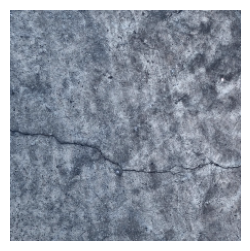

In [ ]:
plt.figure(figsize=(3, 3))
plt.imshow(0.25 * test_ds[0][0].permute(1, 2, 0) + 0.5)
plt.axis('off')


# We will create ensmeble model so first we will create the individual models, train and evalaute them separately then we will combine and evalaute them in an ensmeble

## Create 1st Model

In [ ]:
config.model_name = 'deeplabv3plus_resnet50'
model = get_model(config.model_name, config.classes, pretrained=False)
replace_batchnorm2d(model, smart_group_norm)

## Training Setting

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
# # optimizer = optim.SGD(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)

lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, config.epochs*len(train_loader), config.lr * 1e-3)
criterion = DiceLoss(activation=config.activation)

if config.model_name in ['deepcrack18', 'deepcrack19', 'hed', 'rcf']:
    if config.model_name == 'deepcrack18':
        weight_side = [1, 1, 1, 1, 1]
        fused_index = 0
    elif config.model_name == 'deepcrack19':
        weight_side = [0.5, 0.75, 1.0, 0.75, 0.5]
        fused_index = -1
    elif config.model_name == 'hed':
        weight_side = [1, 1, 1, 1, 1]
        fused_index = -1
    elif config.model_name == 'rcf':
        weight_side = [1, 1, 1, 1, 1]
        fused_index = -1
    trainer = DeepCrackTrainer(model, optimizer, criterion, num_accum_steps=config.num_accum_steps,
                               weight_side=weight_side, fused_index=fused_index,
                               lr_scheduler=lr_scheduler, use_amp=False, use_cuda=True)
else:
    trainer = SegmentationTrainer(model, optimizer, criterion, num_accum_steps=config.num_accum_steps,
                                      lr_scheduler=lr_scheduler, use_amp=True, use_cuda=True)

## Train

In [ ]:
# trainer.lr_scheduler = None
history = trainer.fit(train_loader, val_loader=test_loader, epochs=config.epochs)

### save results ###
torch.save(model.state_dict(), 'deeplabv3plus_resnet50_DiceLoss.pt')

with open('history.json', "w") as f:
    json.dump(history, f)


Eval: 100%|██████████| 35/35 [00:09<00:00,  3.88it/s, loss=0.347, pixel_acc=0.984, iou=0.498, dice=0.656, precision=0.641, recall=0.694]


# Evaluate 1st model

In [ ]:
N = 1
returned_metrics_ = None

for i in range(N):
    #best_thresh, pixel_acc, mean_pixel_acc, precision, recall, iou, miou, ODS,OIS, AP
    results= edge_detection_metrics(trainer, test_loader)
    returned_metrics = trainer.evaluate(test_loader)

    if returned_metrics_ is None:
        returned_metrics_ = returned_metrics
        returned_metrics_['ODS'] = float(results['ODS'])
        returned_metrics_['OIS'] = float(results['OIS'])
        returned_metrics_['mAP'] = float(results['AP'])
    else:
        for k, v in returned_metrics.items():
            returned_metrics_[k] += returned_metrics[k]
        returned_metrics_['ODS'] += float(results['ODS'])
        returned_metrics_['OIS'] += float(results['OIS'])
        returned_metrics_['mAP'] += float(results['AP'])

for k, v in returned_metrics_.items():
    returned_metrics_[k] = v / N

returned_metrics = returned_metrics_

print('| ' + ' | '.join(list(returned_metrics.keys())) + ' |')
print('| ' + ' | '.join([str(round(float(v)*100, 2)) for v in returned_metrics.values()]) + ' |')


Eval: 100%|██████████| 35/35 [00:09<00:00,  3.61it/s, loss=0.347, pixel_acc=0.984, iou=0.498, dice=0.656, precision=0.641, recall=0.694]


| loss | pixel_acc | iou | dice | precision | recall | ODS | OIS | mAP |
| 34.68 | 98.39 | 49.79 | 65.61 | 64.12 | 69.43 | 65.61 | 66.45 | 68.07 |


### Learning Curves

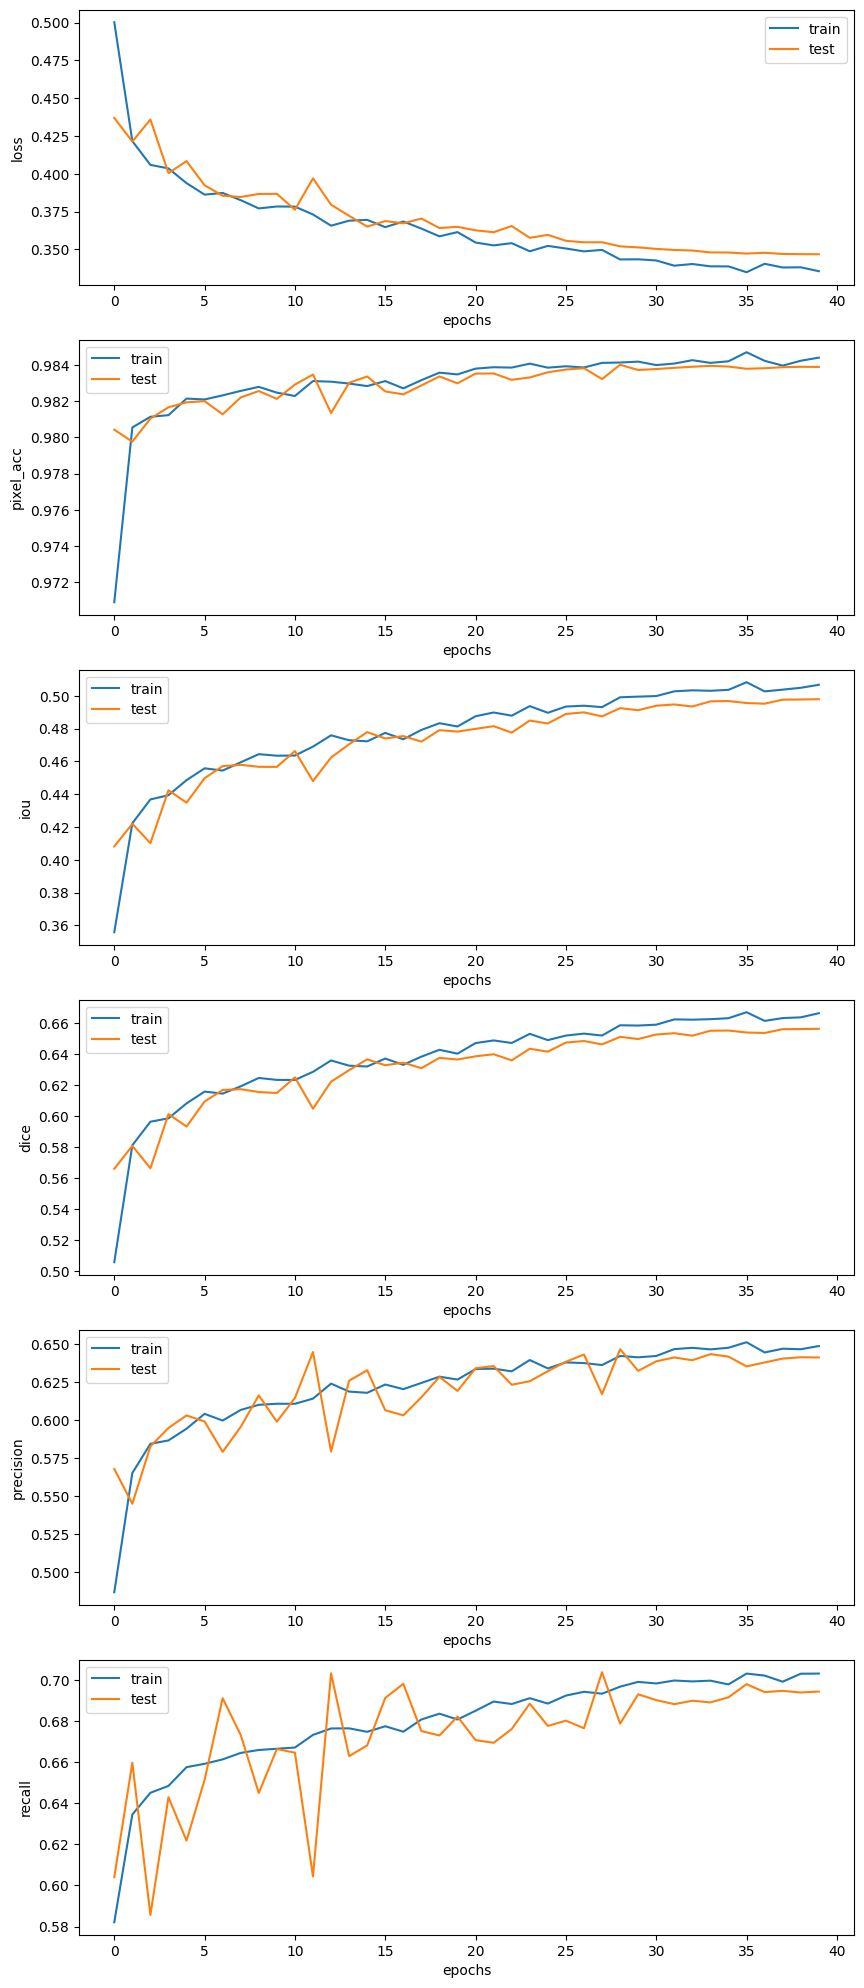

In [ ]:
plt.figure(figsize=(10, 25))

plt.subplot(6, 1, 1)
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='test')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.subplot(6, 1, 2)
plt.plot(history['pixel_acc'], label='train')
plt.plot(history['val_pixel_acc'], label='test')
plt.xlabel('epochs')
plt.ylabel('pixel_acc')
plt.legend()

plt.subplot(6, 1, 3)
plt.plot(history['iou'], label='train')
plt.plot(history['val_iou'], label='test')
plt.xlabel('epochs')
plt.ylabel('iou')
plt.legend()

plt.subplot(6, 1, 4)
plt.plot(history['dice'], label='train')
plt.plot(history['val_dice'], label='test')
plt.xlabel('epochs')
plt.ylabel('dice')
plt.legend()

plt.subplot(6, 1, 5)
plt.plot(history['precision'], label='train')
plt.plot(history['val_precision'], label='test')
plt.xlabel('epochs')
plt.ylabel('precision')
plt.legend()

plt.subplot(6, 1, 6)
plt.plot(history['recall'], label='train')
plt.plot(history['val_recall'], label='test')
plt.xlabel('epochs')
plt.ylabel('recall')
plt.legend()


### Show Segment Result

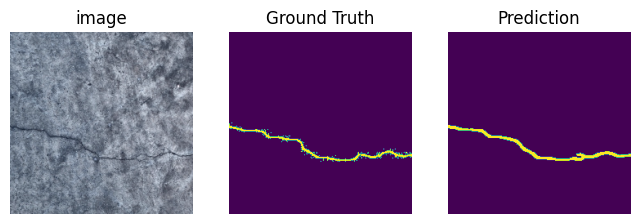

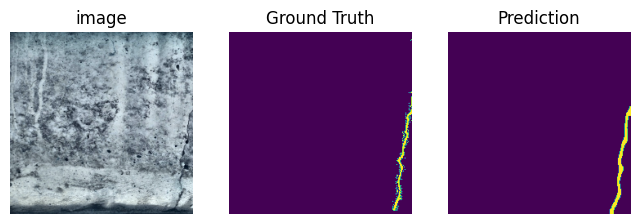

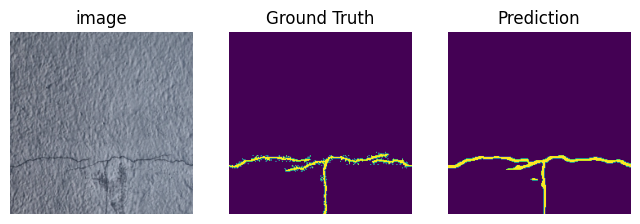

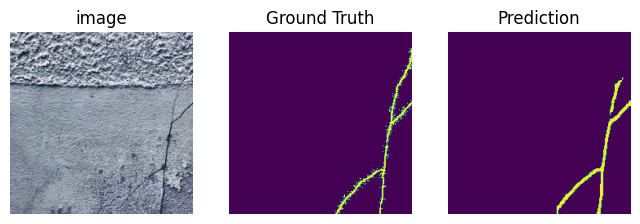

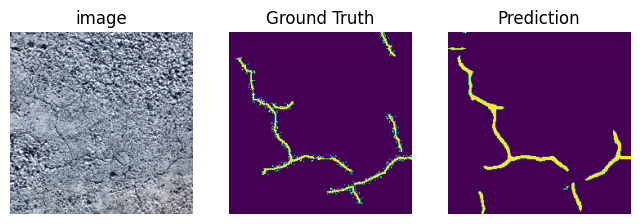

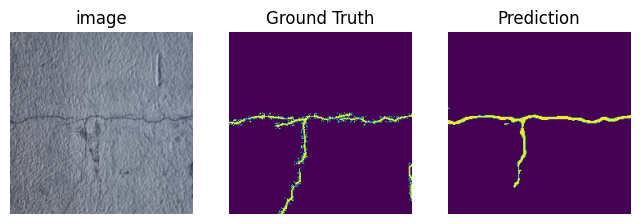

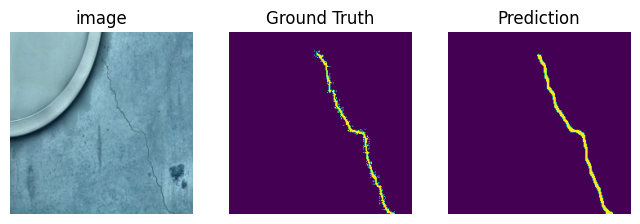

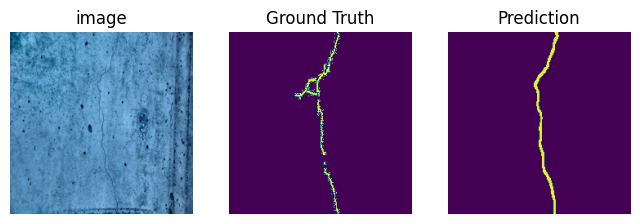

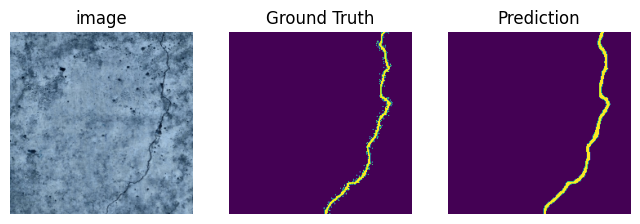

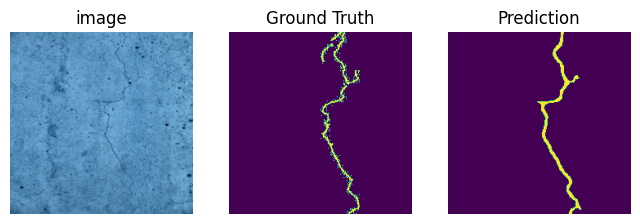

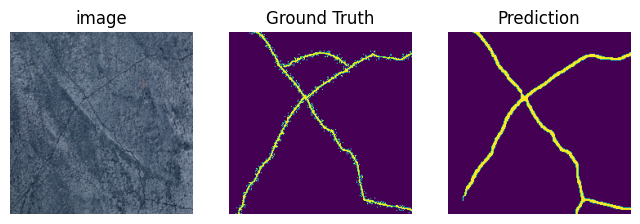

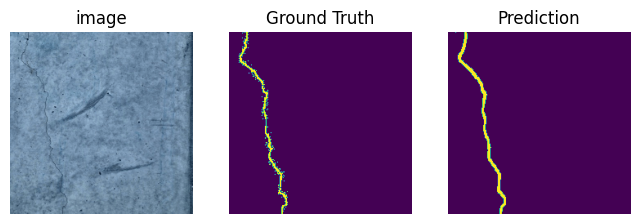

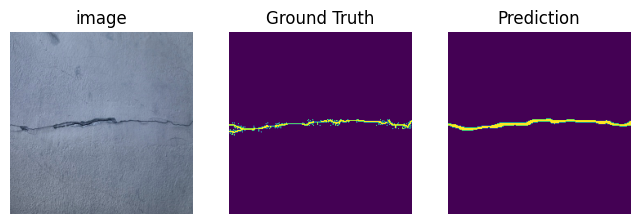

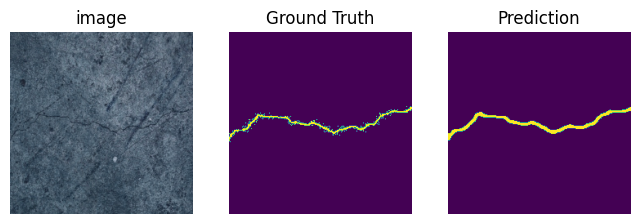

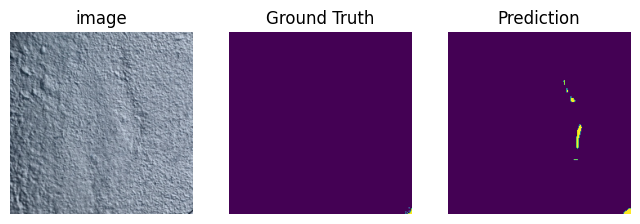

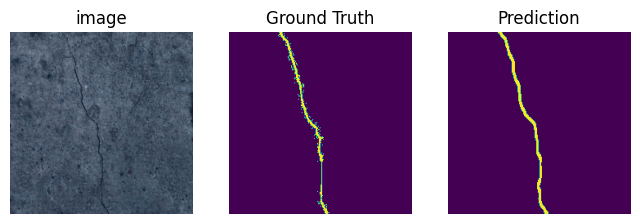

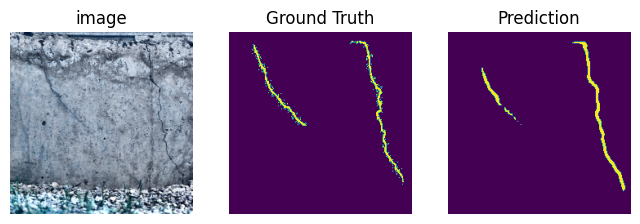

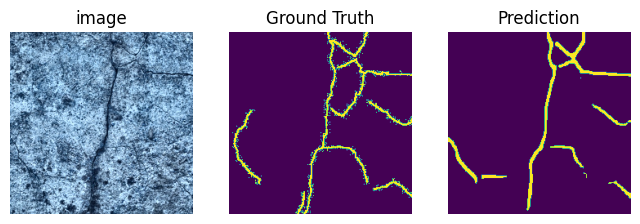

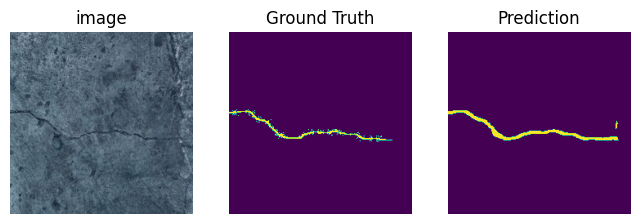

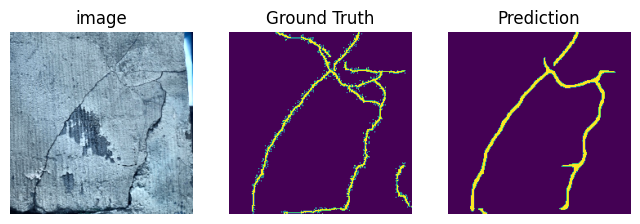

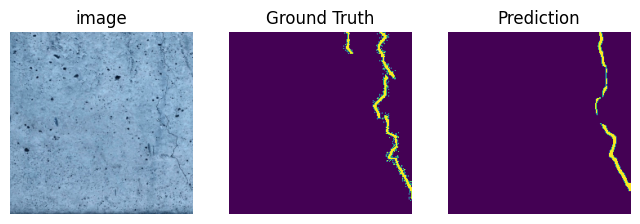

In [ ]:
indexes = [0, 1,2, 3, 4, 5, 6, 7,8,9,10,11, 12, 13,14,15,16,17,18,19,20]


for i in indexes:
    x, y = test_ds[i]
    x, y = x[None], y[None]
    logits = model(trainer._convert_cuda_data(x)).detach().cpu()
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 3, 1)
    plt.title('image')
    plt.imshow(0.25*x[0].permute(1, 2, 0)+0.5)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Ground Truth')
    plt.imshow(y[0])
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Prediction')
    plt.imshow(logits[0, 0] > 0)
    plt.axis('off')

    plt.show()

# Second model

In [ ]:
config.model_name='unet'
model1 = get_model(config.model_name, config.classes, pretrained=False)
replace_batchnorm2d(model1, smart_group_norm)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/milesial/Pytorch-UNet/zipball/master" to /root/.cache/torch/hub/master.zip


## Training Setting

In [ ]:
optimizer = optim.Adam(model1.parameters(), lr=config.lr, weight_decay=config.weight_decay)
# # optimizer = optim.SGD(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)

lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, config.epochs*len(train_loader), config.lr * 1e-3)
criterion = DiceLoss(activation=config.activation)

if config.model_name in ['deepcrack18', 'deepcrack19', 'hed', 'rcf']:
    if config.model_name == 'deepcrack18':
        weight_side = [1, 1, 1, 1, 1]
        fused_index = 0
    elif config.model_name == 'deepcrack19':
        weight_side = [0.5, 0.75, 1.0, 0.75, 0.5]
        fused_index = -1
    elif config.model_name == 'hed':
        weight_side = [1, 1, 1, 1, 1]
        fused_index = -1
    elif config.model_name == 'rcf':
        weight_side = [1, 1, 1, 1, 1]
        fused_index = -1
    trainer = DeepCrackTrainer(model1, optimizer, criterion, num_accum_steps=config.num_accum_steps,
                               weight_side=weight_side, fused_index=fused_index,
                               lr_scheduler=lr_scheduler, use_amp=False, use_cuda=True)
else:
    trainer = SegmentationTrainer(model1, optimizer, criterion, num_accum_steps=config.num_accum_steps,
                                      lr_scheduler=lr_scheduler, use_amp=True, use_cuda=True)

## Train

In [ ]:
# trainer.lr_scheduler = None
history1 = trainer.fit(train_loader, val_loader=test_loader, epochs=config.epochs)

### save results ###
torch.save(model1.state_dict(), 'unet_DiceLoss.pt')

with open('history1.json', "w") as f:
    json.dump(history1, f)


Eval: 100%|██████████| 35/35 [00:09<00:00,  3.85it/s, loss=0.33, pixel_acc=0.985, iou=0.512, dice=0.67, precision=0.659, recall=0.705]


#evaluate 2nd model

In [ ]:
N = 1
returned_metrics_ = None

for i in range(N):
    #best_thresh, pixel_acc, mean_pixel_acc, precision, recall, iou, miou, ODS,OIS, AP
    results= edge_detection_metrics(trainer, test_loader)
    returned_metrics = trainer.evaluate(test_loader)

    if returned_metrics_ is None:
        returned_metrics_ = returned_metrics
        returned_metrics_['ODS'] = float(results['ODS'])
        returned_metrics_['OIS'] = float(results['OIS'])
        returned_metrics_['mAP'] = float(results['AP'])
    else:
        for k, v in returned_metrics.items():
            returned_metrics_[k] += returned_metrics[k]
        returned_metrics_['ODS'] += float(results['ODS'])
        returned_metrics_['OIS'] += float(results['OIS'])
        returned_metrics_['mAP'] += float(results['AP'])

for k, v in returned_metrics_.items():
    returned_metrics_[k] = v / N

returned_metrics = returned_metrics_

print('| ' + ' | '.join(list(returned_metrics.keys())) + ' |')
print('| ' + ' | '.join([str(round(float(v)*100, 2)) for v in returned_metrics.values()]) + ' |')


Eval: 100%|██████████| 35/35 [00:10<00:00,  3.50it/s, loss=0.33, pixel_acc=0.985, iou=0.512, dice=0.67, precision=0.659, recall=0.705]

| loss | pixel_acc | iou | dice | precision | recall | ODS | OIS | mAP |
| 32.98 | 98.48 | 51.24 | 67.04 | 65.9 | 70.46 | 67.39 | 67.93 | 69.36 |


### Learning Curves

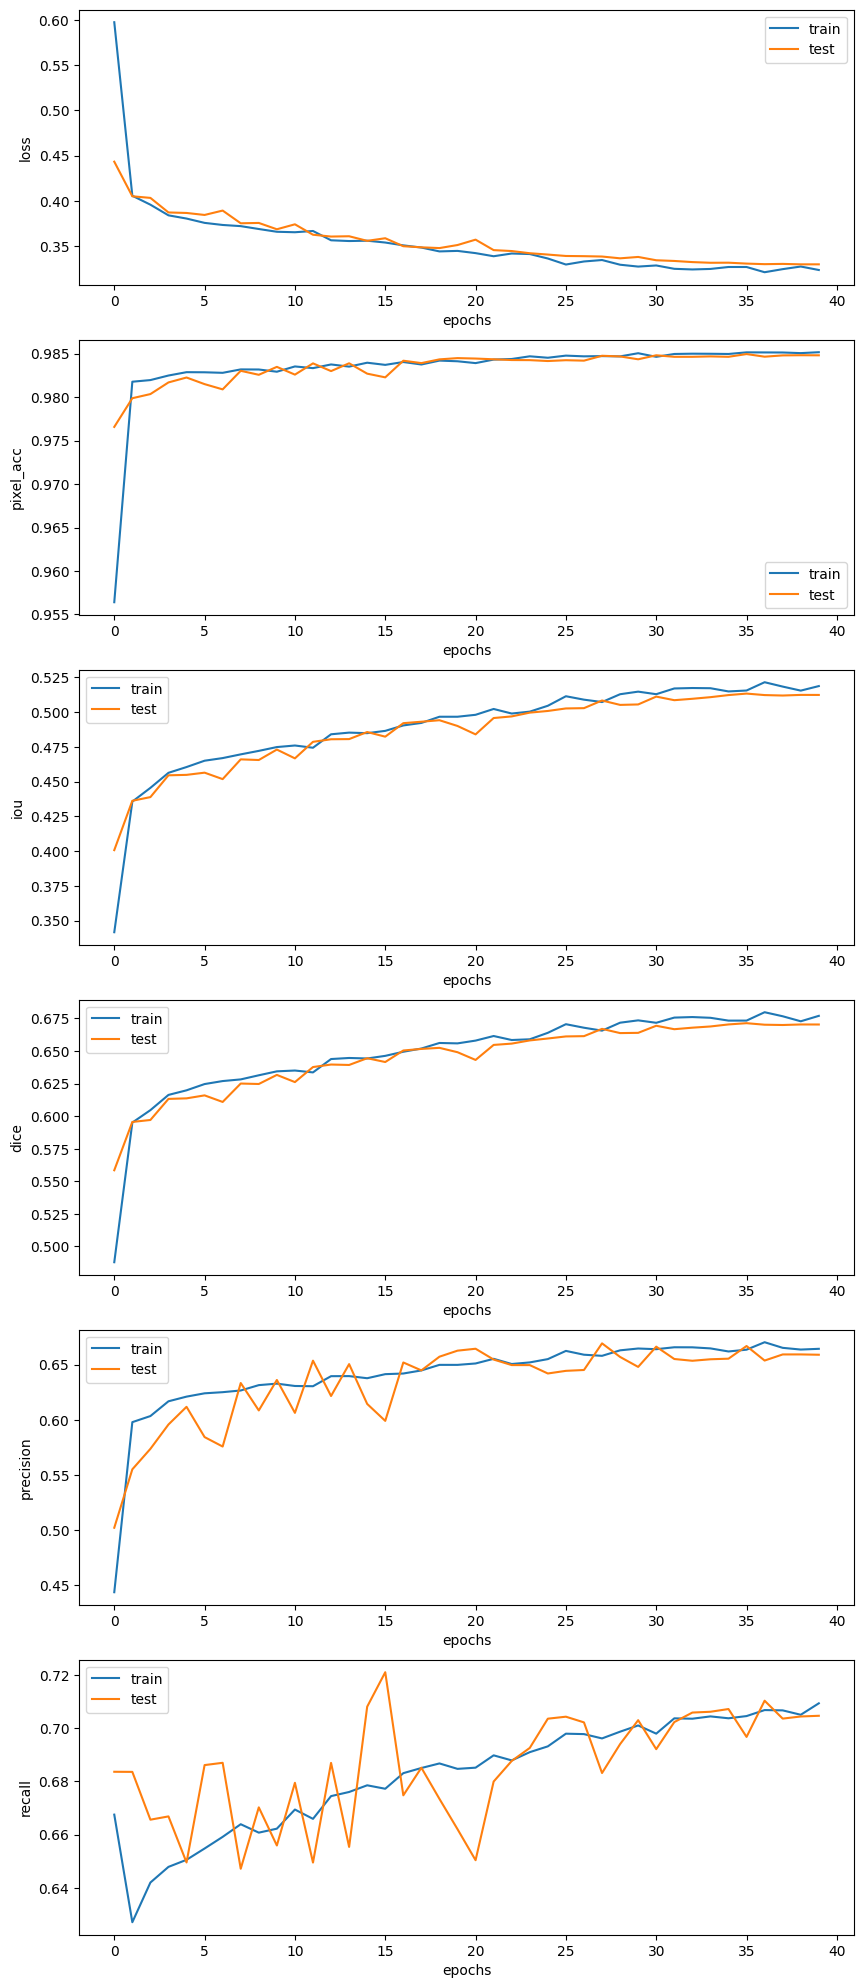

In [ ]:
plt.figure(figsize=(10, 25))

plt.subplot(6, 1, 1)
plt.plot(history1['loss'], label='train')
plt.plot(history1['val_loss'], label='test')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.subplot(6, 1, 2)
plt.plot(history1['pixel_acc'], label='train')
plt.plot(history1['val_pixel_acc'], label='test')
plt.xlabel('epochs')
plt.ylabel('pixel_acc')
plt.legend()

plt.subplot(6, 1, 3)
plt.plot(history1['iou'], label='train')
plt.plot(history1['val_iou'], label='test')
plt.xlabel('epochs')
plt.ylabel('iou')
plt.legend()

plt.subplot(6, 1, 4)
plt.plot(history1['dice'], label='train')
plt.plot(history1['val_dice'], label='test')
plt.xlabel('epochs')
plt.ylabel('dice')
plt.legend()

plt.subplot(6, 1, 5)
plt.plot(history1['precision'], label='train')
plt.plot(history1['val_precision'], label='test')
plt.xlabel('epochs')
plt.ylabel('precision')
plt.legend()

plt.subplot(6, 1, 6)
plt.plot(history1['recall'], label='train')
plt.plot(history1['val_recall'], label='test')
plt.xlabel('epochs')
plt.ylabel('recall')
plt.legend()


### Show Segment Result

In [ ]:
indexes = [0, 1,2, 3, 4, 5, 6, 7,8,9,10,11, 12, 13,14,15,16,17,18,19,20]


for i in indexes:
    x, y = test_ds[i]
    x, y = x[None], y[None]
    logits = model1(trainer._convert_cuda_data(x)).detach().cpu()
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 3, 1)
    plt.title('image')
    plt.imshow(0.25*x[0].permute(1, 2, 0)+0.5)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Ground Truth')
    plt.imshow(y[0])
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Prediction')
    plt.imshow(logits[0, 0] > 0)
    plt.axis('off')

    plt.show()

# Third model

In [ ]:
config.model_name='deepcrack19'
model2 = get_model(config.model_name, config.classes, pretrained=False)
replace_batchnorm2d(model2, smart_group_norm)

Pretrained model is invalid.
initialize network with xavier


## Training Setting

In [ ]:
optimizer = optim.Adam(model2.parameters(), lr=config.lr, weight_decay=config.weight_decay)
# # optimizer = optim.SGD(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)

lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, config.epochs*len(train_loader), config.lr * 1e-3)
criterion = DiceLoss(activation=config.activation)

if config.model_name in ['deepcrack18', 'deepcrack19', 'hed', 'rcf']:
    if config.model_name == 'deepcrack18':
        weight_side = [1, 1, 1, 1, 1]
        fused_index = 0
    elif config.model_name == 'deepcrack19':
        weight_side = [0.5, 0.75, 1.0, 0.75, 0.5]
        fused_index = -1
    elif config.model_name == 'hed':
        weight_side = [1, 1, 1, 1, 1]
        fused_index = -1
    elif config.model_name == 'rcf':
        weight_side = [1, 1, 1, 1, 1]
        fused_index = -1
    trainer = DeepCrackTrainer(model2, optimizer, criterion, num_accum_steps=config.num_accum_steps,
                               weight_side=weight_side, fused_index=fused_index,
                               lr_scheduler=lr_scheduler, use_amp=False, use_cuda=True)
else:
    trainer = SegmentationTrainer(model2, optimizer, criterion, num_accum_steps=config.num_accum_steps,
                                      lr_scheduler=lr_scheduler, use_amp=True, use_cuda=True)

## Train

In [ ]:
# trainer.lr_scheduler = None
history2 = trainer.fit(train_loader, val_loader=test_loader, epochs=16)

### save results ###
torch.save(model2.state_dict(), 'deepcrack19_DiceLoss.pt')

with open('history2.json', "w") as f:
    json.dump(history2, f)


Eval: 100%|██████████| 35/35 [00:09<00:00,  3.67it/s, loss=1.91, pixel_acc=0.984, iou=0.489, dice=0.648, precision=0.656, recall=0.658]


In [ ]:
# trainer.lr_scheduler = None
history2 = trainer.fit(train_loader, val_loader=test_loader, epochs=24)

### save results ###
torch.save(model2.state_dict(), 'deepcrack19_DiceLoss.pt')

with open('history2.json', "w") as f:
    json.dump(history2, f)

Eval: 100%|██████████| 35/35 [00:07<00:00,  4.76it/s, loss=1.8, pixel_acc=0.984, iou=0.512, dice=0.671, precision=0.662, recall=0.692]


#evaluate 3rd model

In [ ]:
N = 1
returned_metrics_ = None

for i in range(N):
    #best_thresh, pixel_acc, mean_pixel_acc, precision, recall, iou, miou, ODS,OIS, AP
    results= edge_detection_metrics(trainer, test_loader)
    returned_metrics = trainer.evaluate(test_loader)

    if returned_metrics_ is None:
        returned_metrics_ = returned_metrics
        returned_metrics_['ODS'] = float(results['ODS'])
        returned_metrics_['OIS'] = float(results['OIS'])
        returned_metrics_['mAP'] = float(results['AP'])
    else:
        for k, v in returned_metrics.items():
            returned_metrics_[k] += returned_metrics[k]
        returned_metrics_['ODS'] += float(results['ODS'])
        returned_metrics_['OIS'] += float(results['OIS'])
        returned_metrics_['mAP'] += float(results['AP'])

for k, v in returned_metrics_.items():
    returned_metrics_[k] = v / N

returned_metrics = returned_metrics_

print('| ' + ' | '.join(list(returned_metrics.keys())) + ' |')
print('| ' + ' | '.join([str(round(float(v)*100, 2)) for v in returned_metrics.values()]) + ' |')


Eval: 100%|██████████| 35/35 [00:08<00:00,  4.32it/s, loss=1.8, pixel_acc=0.984, iou=0.512, dice=0.671, precision=0.662, recall=0.692]

| loss | pixel_acc | iou | dice | precision | recall | ODS | OIS | mAP |
| 180.23 | 98.45 | 51.22 | 67.1 | 66.24 | 69.21 | 67.12 | 67.66 | 68.1 |


### Learning Curves

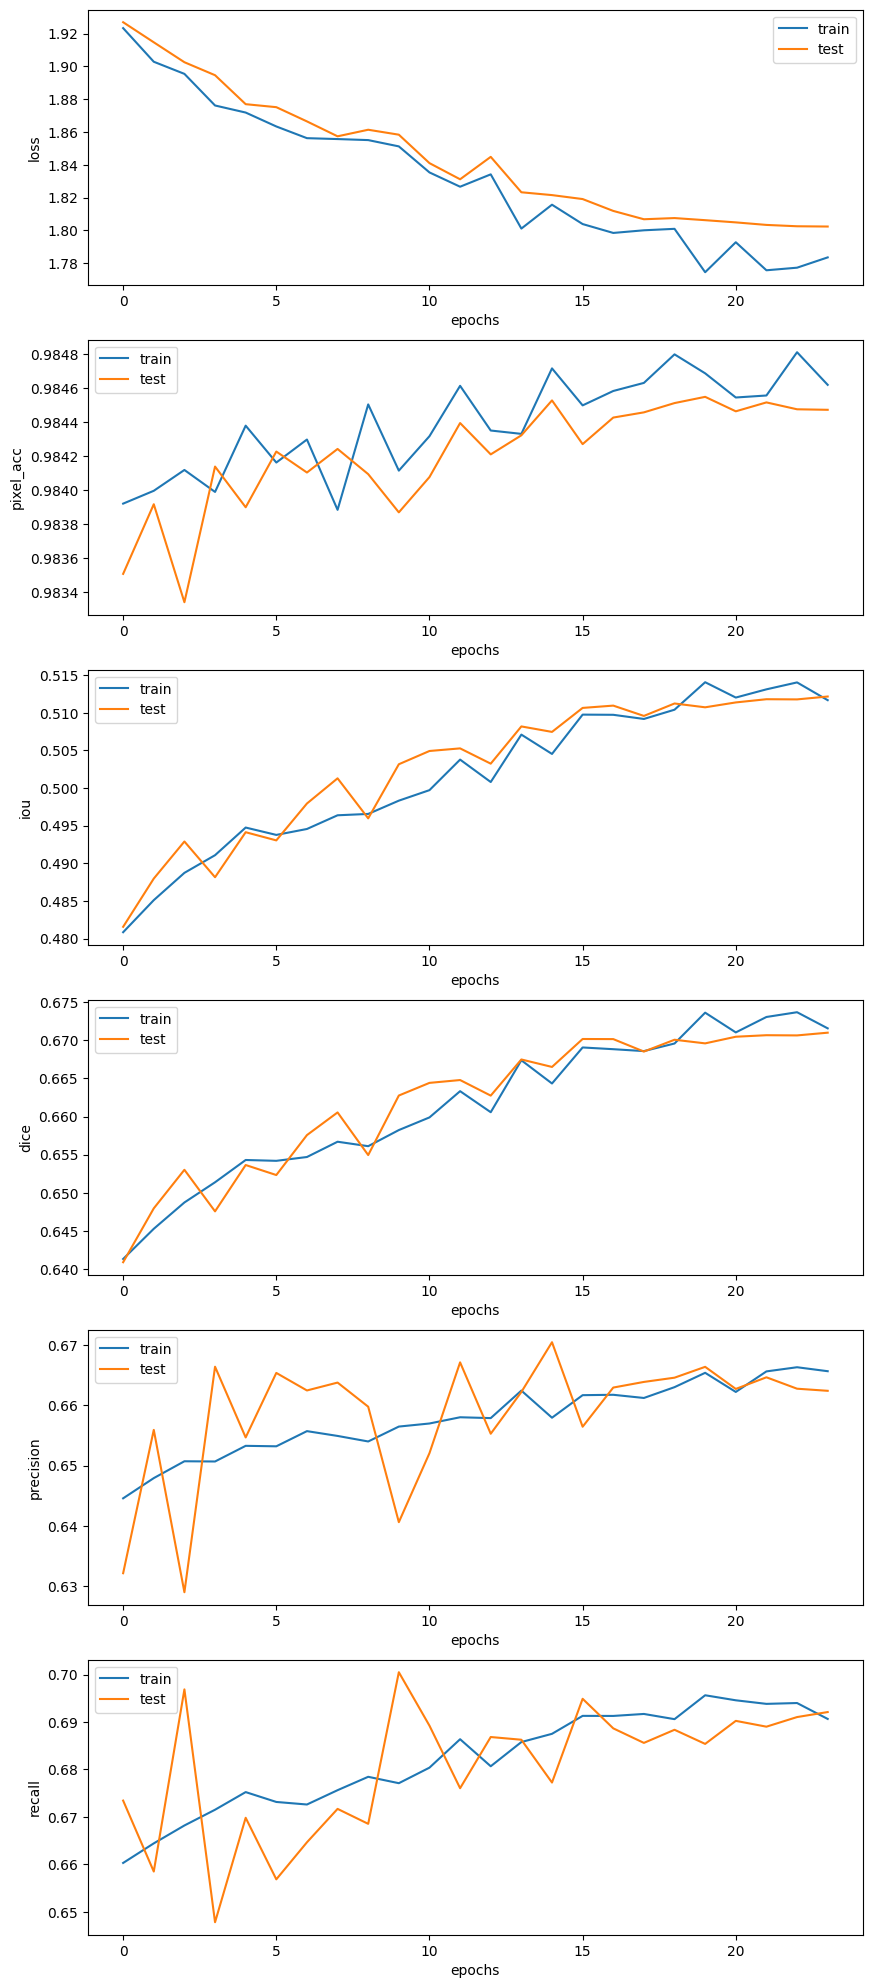

In [ ]:
plt.figure(figsize=(10, 25))

plt.subplot(6, 1, 1)
plt.plot(history2['loss'], label='train')
plt.plot(history2['val_loss'], label='test')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.subplot(6, 1, 2)
plt.plot(history2['pixel_acc'], label='train')
plt.plot(history2['val_pixel_acc'], label='test')
plt.xlabel('epochs')
plt.ylabel('pixel_acc')
plt.legend()

plt.subplot(6, 1, 3)
plt.plot(history2['iou'], label='train')
plt.plot(history2['val_iou'], label='test')
plt.xlabel('epochs')
plt.ylabel('iou')
plt.legend()

plt.subplot(6, 1, 4)
plt.plot(history2['dice'], label='train')
plt.plot(history2['val_dice'], label='test')
plt.xlabel('epochs')
plt.ylabel('dice')
plt.legend()

plt.subplot(6, 1, 5)
plt.plot(history2['precision'], label='train')
plt.plot(history2['val_precision'], label='test')
plt.xlabel('epochs')
plt.ylabel('precision')
plt.legend()

plt.subplot(6, 1, 6)
plt.plot(history2['recall'], label='train')
plt.plot(history2['val_recall'], label='test')
plt.xlabel('epochs')
plt.ylabel('recall')
plt.legend()


### Show Segment Result

In [ ]:
indexes = [0, 1,2, 3, 4, 5, 6, 7,8,9,10,11, 12, 13,14,15,16,17,18,19,20]
for i in indexes:
    x, y = test_ds[i]
    x, y = x[None], y[None]
    output = model2(trainer._convert_cuda_data(x))

    # Unpack the tuple if the output is a tuple
    if isinstance(output, tuple):
        logits = output[0]
    else:
        logits = output

    logits = logits.detach().cpu()
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 3, 1)
    plt.title('image')
    plt.imshow(0.25*x[0].permute(1, 2, 0)+0.5)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Ground Truth')
    plt.imshow(y[0])
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Prediction')
    plt.imshow(logits[0, 0] > 0)
    plt.axis('off')

    plt.show()


# Cretae 4th model

In [ ]:
config.model_name='segnet'
model3 = get_model(config.model_name, config.classes, pretrained=False)
replace_batchnorm2d(model3, smart_group_norm)

## Training Setting

In [ ]:
optimizer = optim.Adam(model3.parameters(), lr=config.lr, weight_decay=config.weight_decay)
# # optimizer = optim.SGD(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)

lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, config.epochs*len(train_loader), config.lr * 1e-3)
criterion = DiceLoss(activation=config.activation)

if config.model_name in ['deepcrack18', 'deepcrack19', 'hed', 'rcf']:
    if config.model_name == 'deepcrack18':
        weight_side = [1, 1, 1, 1, 1]
        fused_index = 0
    elif config.model_name == 'deepcrack19':
        weight_side = [0.5, 0.75, 1.0, 0.75, 0.5]
        fused_index = -1
    elif config.model_name == 'hed':
        weight_side = [1, 1, 1, 1, 1]
        fused_index = -1
    elif config.model_name == 'rcf':
        weight_side = [1, 1, 1, 1, 1]
        fused_index = -1
    trainer = DeepCrackTrainer(model3, optimizer, criterion, num_accum_steps=config.num_accum_steps,
                               weight_side=weight_side, fused_index=fused_index,
                               lr_scheduler=lr_scheduler, use_amp=False, use_cuda=True)
else:
    trainer = SegmentationTrainer(model3, optimizer, criterion, num_accum_steps=config.num_accum_steps,
                                      lr_scheduler=lr_scheduler, use_amp=True, use_cuda=True)

## Train

In [ ]:
# trainer.lr_scheduler = None
history3 = trainer.fit(train_loader, val_loader=test_loader, epochs=config.epochs)

### save results ###
torch.save(model3.state_dict(), 'segnet_DiceLoss.pt')

with open('history3.json', "w") as f:
    json.dump(history3, f)


Eval: 100%|██████████| 35/35 [00:09<00:00,  3.56it/s, loss=0.339, pixel_acc=0.984, iou=0.502, dice=0.661, precision=0.651, recall=0.693]


# Evaluate 4th model

In [ ]:
N = 1
returned_metrics_ = None

for i in range(N):
    #best_thresh, pixel_acc, mean_pixel_acc, precision, recall, iou, miou, ODS,OIS, AP
    results= edge_detection_metrics(trainer, test_loader)
    returned_metrics = trainer.evaluate(test_loader)

    if returned_metrics_ is None:
        returned_metrics_ = returned_metrics
        returned_metrics_['ODS'] = float(results['ODS'])
        returned_metrics_['OIS'] = float(results['OIS'])
        returned_metrics_['mAP'] = float(results['AP'])
    else:
        for k, v in returned_metrics.items():
            returned_metrics_[k] += returned_metrics[k]
        returned_metrics_['ODS'] += float(results['ODS'])
        returned_metrics_['OIS'] += float(results['OIS'])
        returned_metrics_['mAP'] += float(results['AP'])

for k, v in returned_metrics_.items():
    returned_metrics_[k] = v / N

returned_metrics = returned_metrics_

print('| ' + ' | '.join(list(returned_metrics.keys())) + ' |')
print('| ' + ' | '.join([str(round(float(v)*100, 2)) for v in returned_metrics.values()]) + ' |')


Eval: 100%|██████████| 35/35 [00:09<00:00,  3.74it/s, loss=0.339, pixel_acc=0.984, iou=0.502, dice=0.661, precision=0.651, recall=0.693]

| loss | pixel_acc | iou | dice | precision | recall | ODS | OIS | mAP |
| 33.94 | 98.41 | 50.22 | 66.09 | 65.13 | 69.31 | 66.09 | 66.73 | 68.35 |


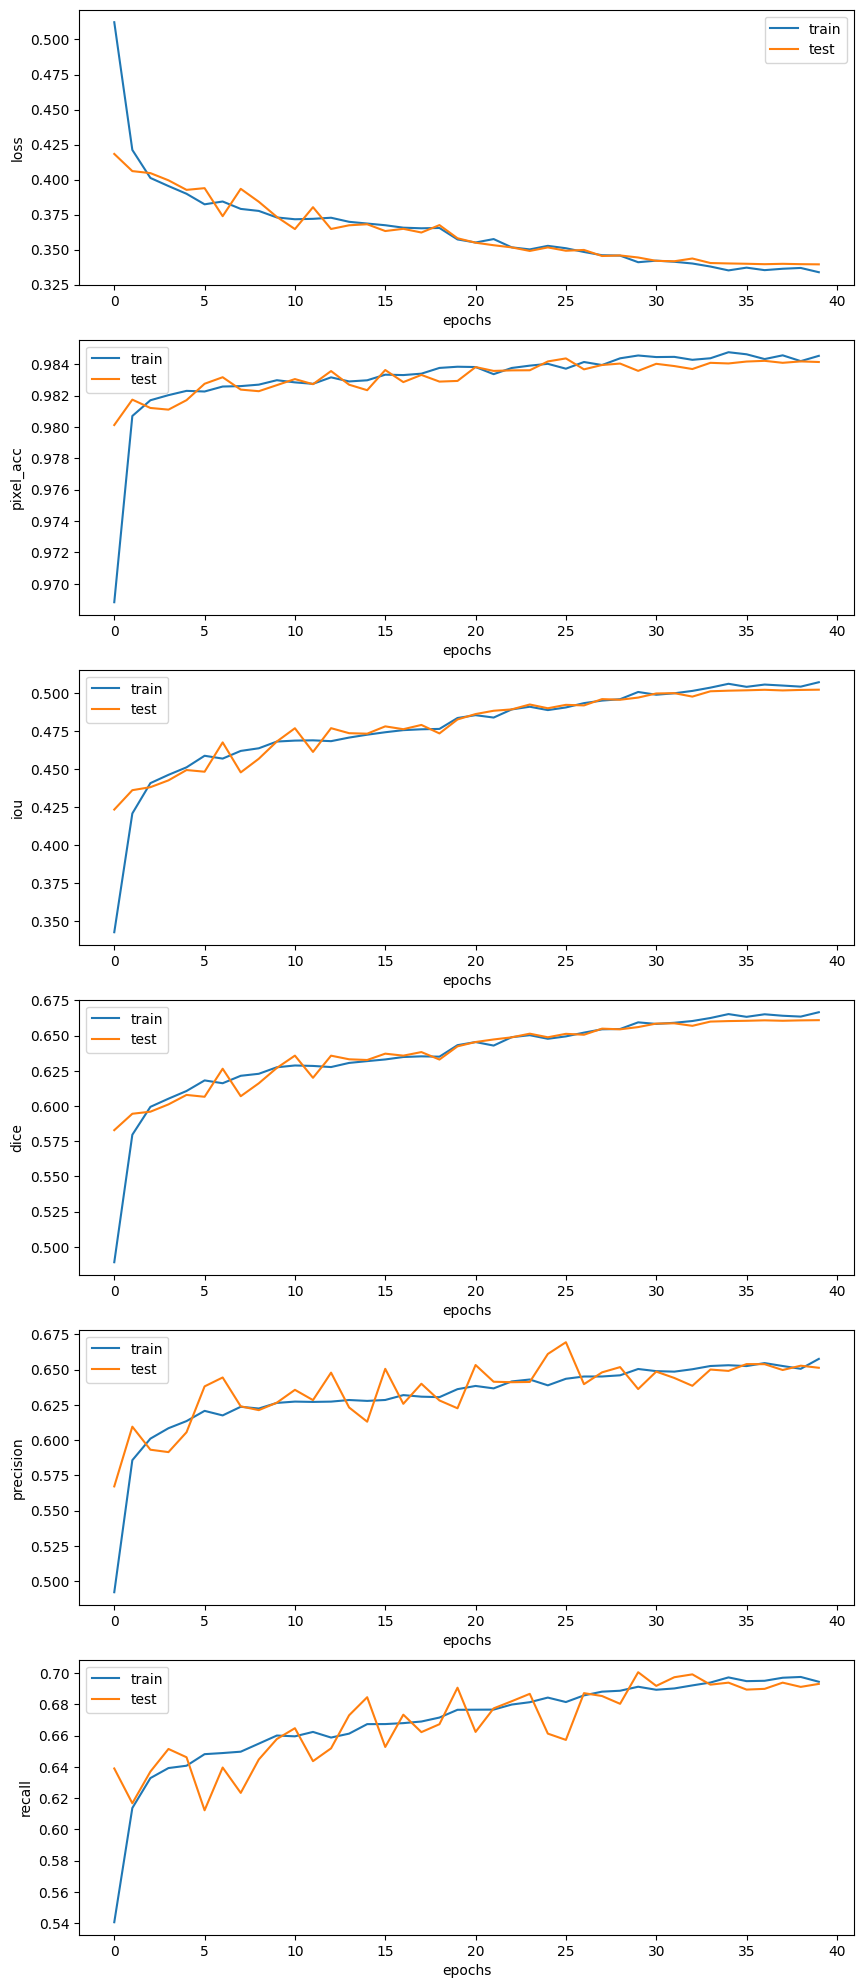

In [ ]:
plt.figure(figsize=(10, 25))

plt.subplot(6, 1, 1)
plt.plot(history3['loss'], label='train')
plt.plot(history3['val_loss'], label='test')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.subplot(6, 1, 2)
plt.plot(history3['pixel_acc'], label='train')
plt.plot(history3['val_pixel_acc'], label='test')
plt.xlabel('epochs')
plt.ylabel('pixel_acc')
plt.legend()

plt.subplot(6, 1, 3)
plt.plot(history3['iou'], label='train')
plt.plot(history3['val_iou'], label='test')
plt.xlabel('epochs')
plt.ylabel('iou')
plt.legend()

plt.subplot(6, 1, 4)
plt.plot(history3['dice'], label='train')
plt.plot(history3['val_dice'], label='test')
plt.xlabel('epochs')
plt.ylabel('dice')
plt.legend()

plt.subplot(6, 1, 5)
plt.plot(history3['precision'], label='train')
plt.plot(history3['val_precision'], label='test')
plt.xlabel('epochs')
plt.ylabel('precision')
plt.legend()

plt.subplot(6, 1, 6)
plt.plot(history3['recall'], label='train')
plt.plot(history3['val_recall'], label='test')
plt.xlabel('epochs')
plt.ylabel('recall')
plt.legend()


### Show Segment Result

In [ ]:
indexes = [0, 1,2, 3, 4, 5, 6, 7,8,9,10,11, 12, 13,14,15,16,17,18,19,20]


for i in indexes:
    x, y = test_ds[i]
    x, y = x[None], y[None]
    logits = model3(trainer._convert_cuda_data(x)).detach().cpu()
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 3, 1)
    plt.title('image')
    plt.imshow(0.25*x[0].permute(1, 2, 0)+0.5)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Ground Truth')
    plt.imshow(y[0])
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Prediction')
    plt.imshow(logits[0, 0] > 0)
    plt.axis('off')

    plt.show()

# Cretae 5th model

In [ ]:
config.model_name='deeplabv3plus_resnet101'
model4 = get_model(config.model_name, config.classes, pretrained=False)
replace_batchnorm2d(model4, smart_group_norm)

## Training Setting

In [ ]:
optimizer = optim.Adam(model4.parameters(), lr=config.lr, weight_decay=config.weight_decay)
# # optimizer = optim.SGD(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)

lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, config.epochs*len(train_loader), config.lr * 1e-3)
criterion = DiceLoss(activation=config.activation)

if config.model_name in ['deepcrack18', 'deepcrack19', 'hed', 'rcf']:
    if config.model_name == 'deepcrack18':
        weight_side = [1, 1, 1, 1, 1]
        fused_index = 0
    elif config.model_name == 'deepcrack19':
        weight_side = [0.5, 0.75, 1.0, 0.75, 0.5]
        fused_index = -1
    elif config.model_name == 'hed':
        weight_side = [1, 1, 1, 1, 1]
        fused_index = -1
    elif config.model_name == 'rcf':
        weight_side = [1, 1, 1, 1, 1]
        fused_index = -1
    trainer = DeepCrackTrainer(model4, optimizer, criterion, num_accum_steps=config.num_accum_steps,
                               weight_side=weight_side, fused_index=fused_index,
                               lr_scheduler=lr_scheduler, use_amp=False, use_cuda=True)
else:
    trainer = SegmentationTrainer(model4, optimizer, criterion, num_accum_steps=config.num_accum_steps,
                                      lr_scheduler=lr_scheduler, use_amp=True, use_cuda=True)

## Train

In [ ]:
# trainer.lr_scheduler = None
history4 = trainer.fit(train_loader, val_loader=test_loader, epochs=config.epochs)

### save results ###
torch.save(model4.state_dict(), 'deeplabv3plus_resnet101.pt')

with open('history4.json', "w") as f:
    json.dump(history4, f)


Eval: 100%|██████████| 35/35 [00:10<00:00,  3.22it/s, loss=0.346, pixel_acc=0.984, iou=0.498, dice=0.657, precision=0.642, recall=0.694]


# Evaluate 5th model

In [ ]:
N = 1
returned_metrics_ = None

for i in range(N):
    #best_thresh, pixel_acc, mean_pixel_acc, precision, recall, iou, miou, ODS,OIS, AP
    results= edge_detection_metrics(trainer, test_loader)
    returned_metrics = trainer.evaluate(test_loader)

    if returned_metrics_ is None:
        returned_metrics_ = returned_metrics
        returned_metrics_['ODS'] = float(results['ODS'])
        returned_metrics_['OIS'] = float(results['OIS'])
        returned_metrics_['mAP'] = float(results['AP'])
    else:
        for k, v in returned_metrics.items():
            returned_metrics_[k] += returned_metrics[k]
        returned_metrics_['ODS'] += float(results['ODS'])
        returned_metrics_['OIS'] += float(results['OIS'])
        returned_metrics_['mAP'] += float(results['AP'])

for k, v in returned_metrics_.items():
    returned_metrics_[k] = v / N

returned_metrics = returned_metrics_

print('| ' + ' | '.join(list(returned_metrics.keys())) + ' |')
print('| ' + ' | '.join([str(round(float(v)*100, 2)) for v in returned_metrics.values()]) + ' |')


Eval: 100%|██████████| 35/35 [00:11<00:00,  3.07it/s, loss=0.346, pixel_acc=0.984, iou=0.498, dice=0.657, precision=0.642, recall=0.694]

| loss | pixel_acc | iou | dice | precision | recall | ODS | OIS | mAP |
| 34.57 | 98.38 | 49.82 | 65.71 | 64.16 | 69.38 | 65.71 | 66.5 | 68.0 |


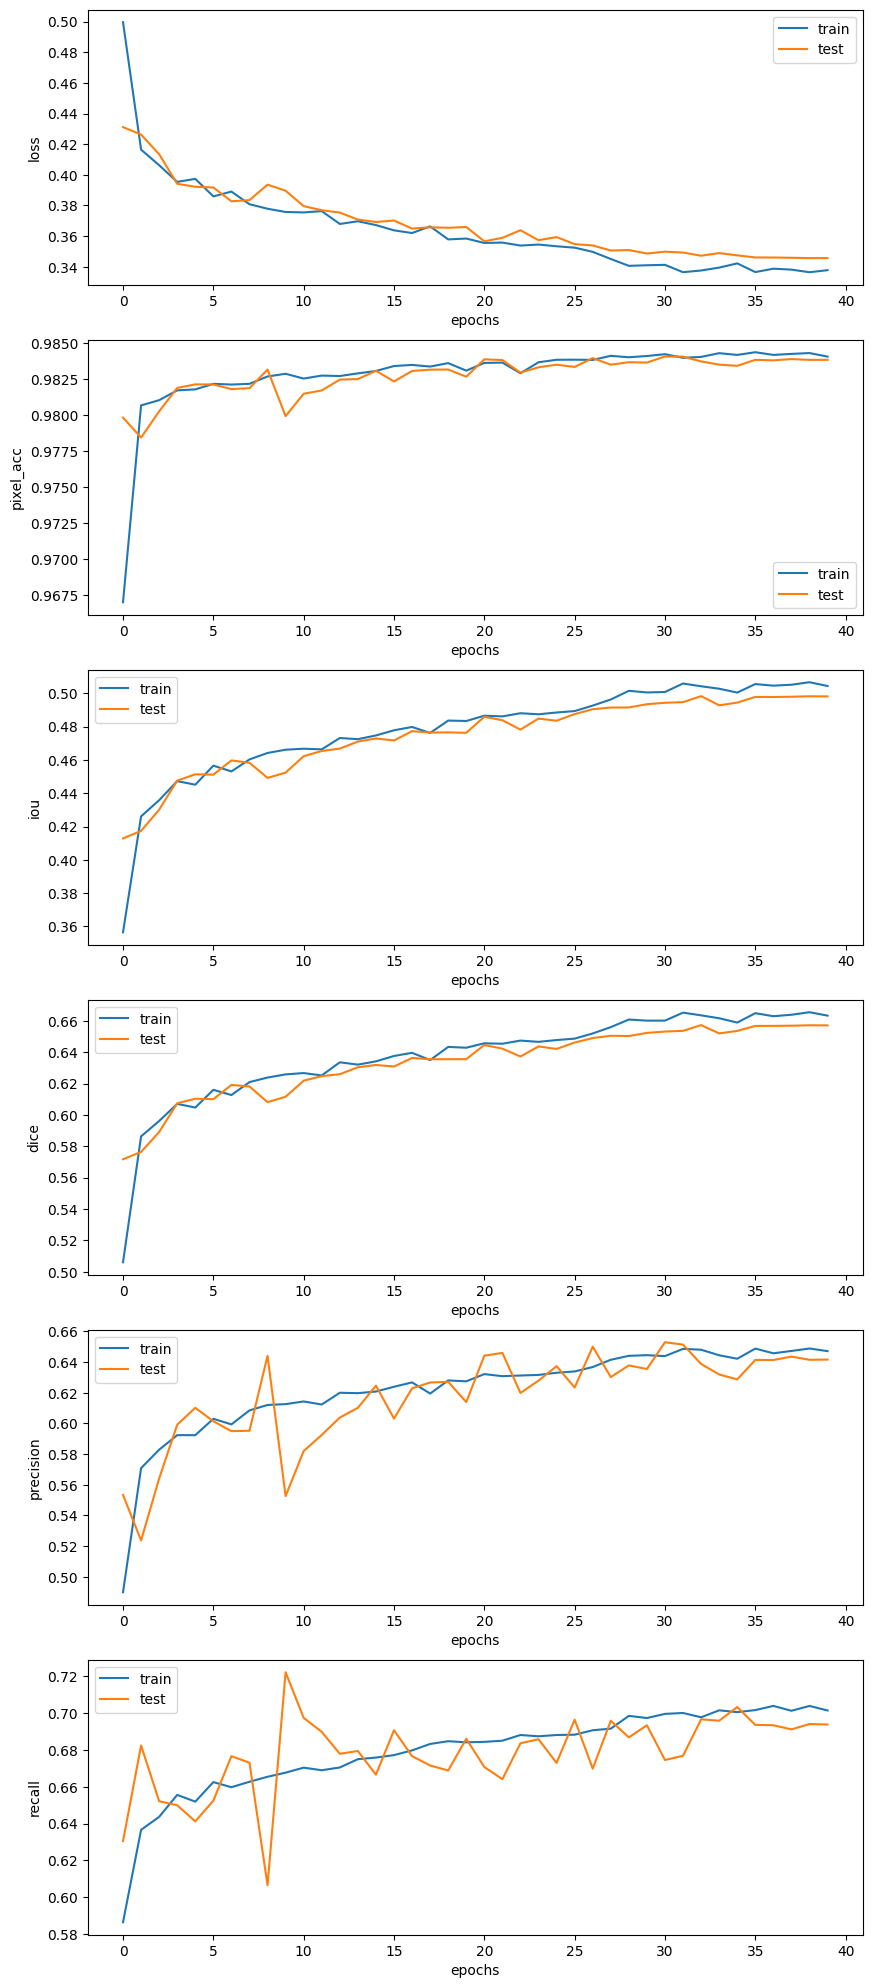

In [ ]:
plt.figure(figsize=(10, 25))

plt.subplot(6, 1, 1)
plt.plot(history4['loss'], label='train')
plt.plot(history4['val_loss'], label='test')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.subplot(6, 1, 2)
plt.plot(history4['pixel_acc'], label='train')
plt.plot(history4['val_pixel_acc'], label='test')
plt.xlabel('epochs')
plt.ylabel('pixel_acc')
plt.legend()

plt.subplot(6, 1, 3)
plt.plot(history4['iou'], label='train')
plt.plot(history4['val_iou'], label='test')
plt.xlabel('epochs')
plt.ylabel('iou')
plt.legend()

plt.subplot(6, 1, 4)
plt.plot(history4['dice'], label='train')
plt.plot(history4['val_dice'], label='test')
plt.xlabel('epochs')
plt.ylabel('dice')
plt.legend()

plt.subplot(6, 1, 5)
plt.plot(history4['precision'], label='train')
plt.plot(history4['val_precision'], label='test')
plt.xlabel('epochs')
plt.ylabel('precision')
plt.legend()

plt.subplot(6, 1, 6)
plt.plot(history4['recall'], label='train')
plt.plot(history4['val_recall'], label='test')
plt.xlabel('epochs')
plt.ylabel('recall')
plt.legend()


### Show Segment Result

In [ ]:
indexes = [0, 1,2, 3, 4, 5, 6, 7,8,9,10,11, 12, 13,14,15,16,17,18,19,20]


for i in indexes:
    x, y = test_ds[i]
    x, y = x[None], y[None]
    logits = model4(trainer._convert_cuda_data(x)).detach().cpu()
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 3, 1)
    plt.title('image')
    plt.imshow(0.25*x[0].permute(1, 2, 0)+0.5)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Ground Truth')
    plt.imshow(y[0])
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Prediction')
    plt.imshow(logits[0, 0] > 0)
    plt.axis('off')

    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Make and evaluate the ensemble model

In [ ]:
def load_model(model_name, num_classes, pretrained=False, device='cuda'):
    model = get_model(model_name, num_classes, pretrained)
    replace_batchnorm2d(model, smart_group_norm)
    model.load_state_dict(torch.load('/content/drive/MyDrive/CrackSegD2/'+ model_name + '.pt'))
    model = model.to(device)  # Move model to the specified device
    model.eval()
    return model

# Example: Load models onto the GPU
deeplab_model = load_model('deeplabv3plus_resnet50', config.classes, device='cuda')
unet_model = load_model('unet', config.classes, device='cuda')
deepcrack_model = load_model('deepcrack19', config.classes, device='cuda')
segnet_model = load_model('segnet', config.classes, device='cuda')
deeplab_model2 = load_model('deeplabv3plus_resnet101', config.classes, device='cuda')

Using cache found in /root/.cache/torch/hub/milesial_Pytorch-UNet_master


Pretrained model is invalid.
initialize network with xavier


In [ ]:
def edge_detection_metrics_single_sample(trainer, sample, from_logits=True, eps=1e-7):
    '''  Only for binary segmentation '''
    x, y, *_ = sample
    x = trainer._convert_cuda_data(x[None])
    with trainer.autocast():
        with torch.no_grad():
            output = trainer.model(x)

            # Unpack the tuple if the output is a tuple
            if isinstance(output, tuple):
                logits = output[0]
            else:
                logits = output

            logits = logits.detach().cpu().float()
    outputs = _edge_detection_metrics_iteration(logits, y[None], from_logits=from_logits, eps=eps)
    pixel_acc, mean_pixel_acc, f1_scores, precision, recall, iou, miou, ap_list = outputs
    thresh_idx = torch.argmax(f1_scores.mean(dim=0)) # best thresh is depanded on f1_score
    pixel_acc = pixel_acc[:, thresh_idx].mean()
    mean_pixel_acc = mean_pixel_acc[:, thresh_idx].mean()
    ODS = f1_scores[:, thresh_idx].mean()
    precision = precision[:, thresh_idx].mean()
    recall = recall[:, thresh_idx].mean()
    iou = iou[:, thresh_idx].mean()
    miou = miou[:, thresh_idx].mean()
    OIS = f1_scores.max(dim=1)[0].mean()
    AP = ap_list.mean()
    best_thresh = torch.arange(0, 1, 0.01).flip(0)[thresh_idx]
    results = {
        'thresh': best_thresh,
        'pixel_acc': pixel_acc,
        'mean_pixel_acc': mean_pixel_acc,
        'precision': precision,
        'recall': recall,
        'iou': iou,
        'miou': miou,
        'ODS': ODS,
        'OIS': OIS,
        'AP': AP
    }
    return {k:float(v) for k, v in results.items()}


# Ensmeble using the best dice score

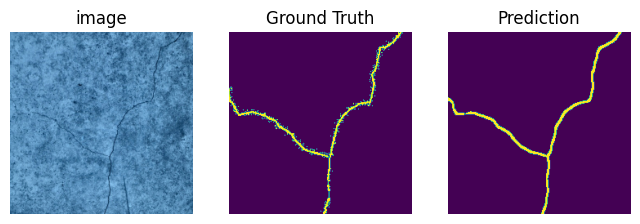

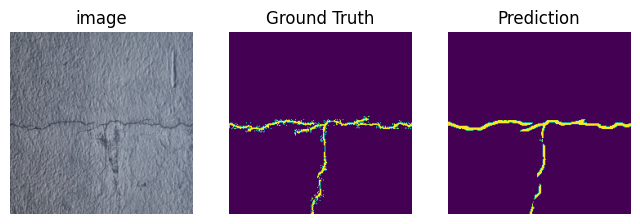

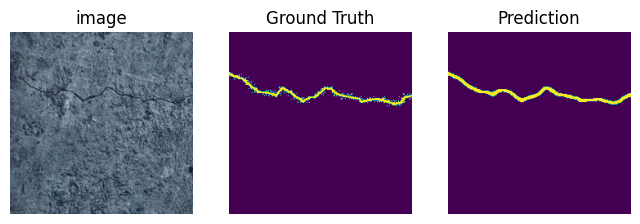

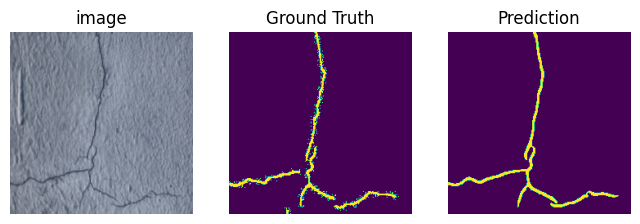

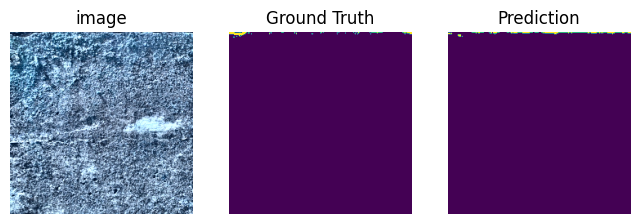

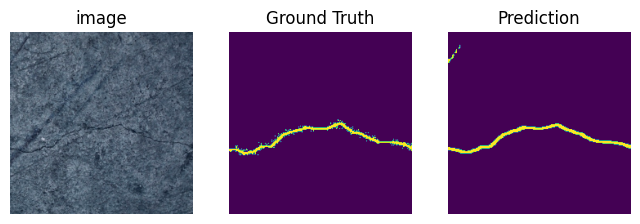

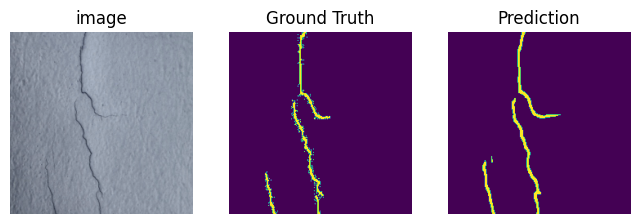

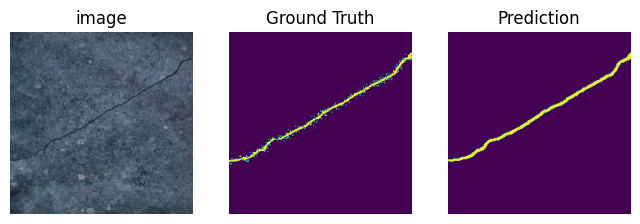

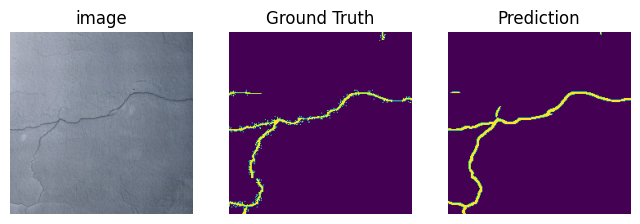

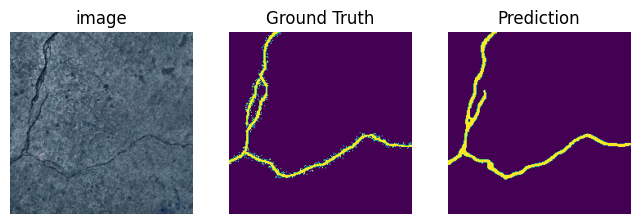

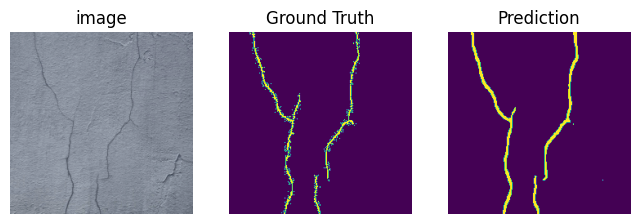

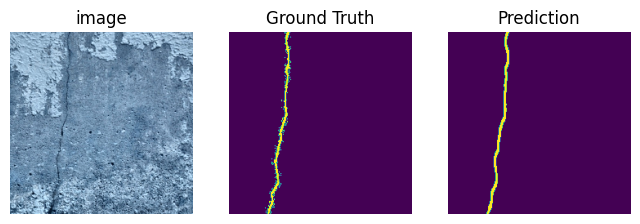

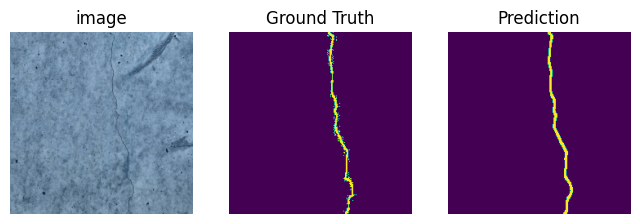

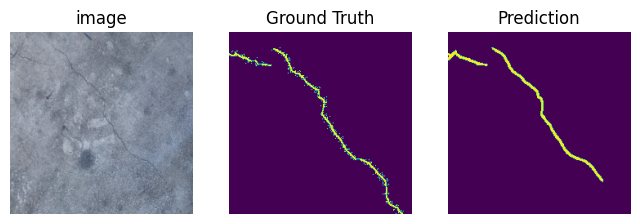

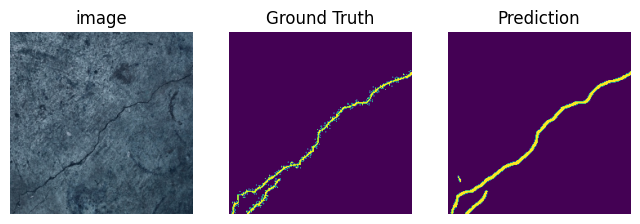

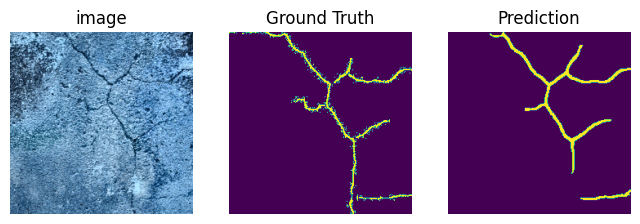

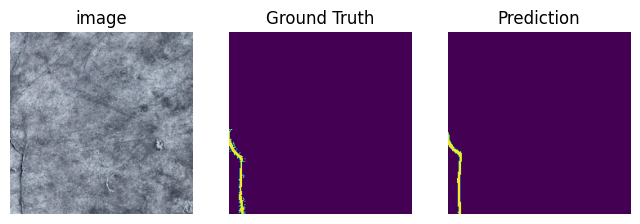

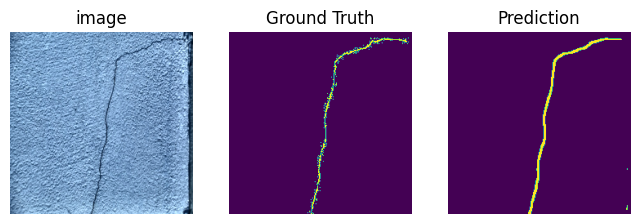

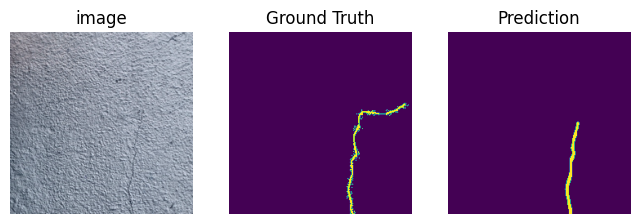

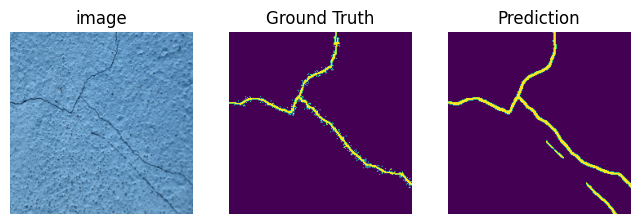

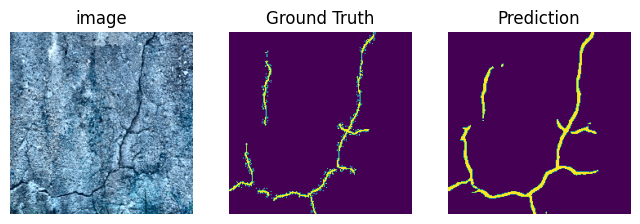

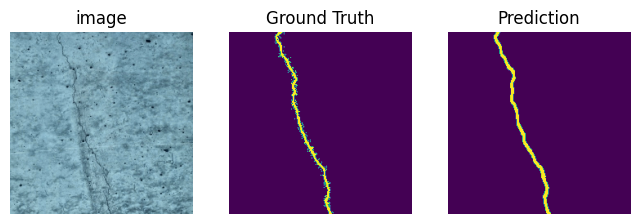

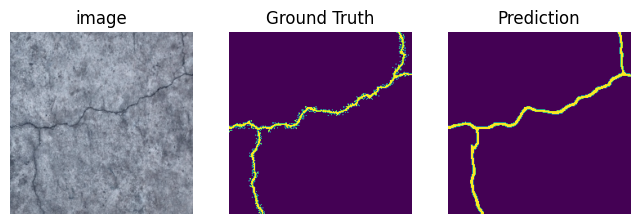

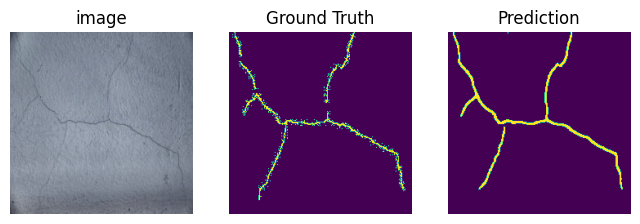

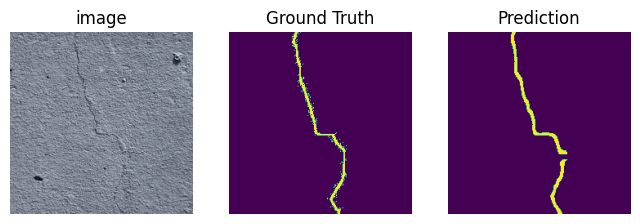

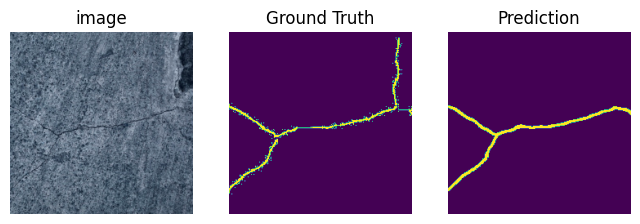

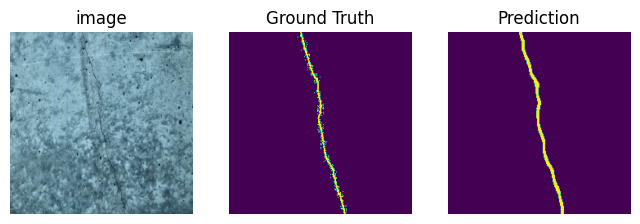

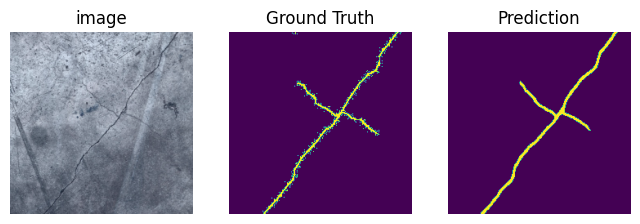

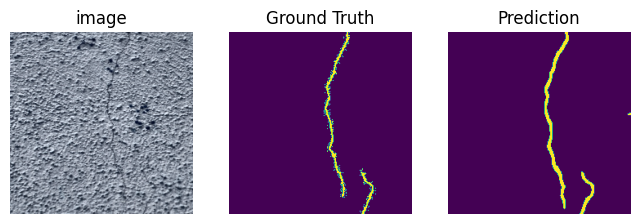

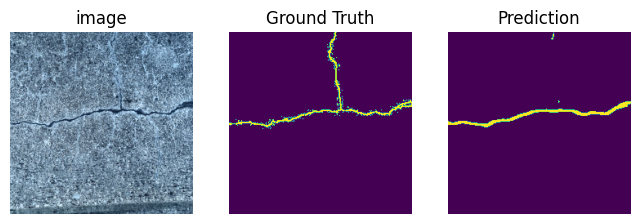

In [ ]:
indexes = [0, 1,2, 3, 4, 5, 6, 7,8,9,10,11, 12, 13,14,15,16,17,18,19,20]

for i in range(0,30):
    x, y = test_ds[i]
    best_dice_score = -1
    best_logits = None

    for model in [deeplab_model, unet_model, deepcrack_model, segnet_model,deeplab_model2]:
        trainer.model = model  # Set the current model in the trainer

        # Evaluate model
        with torch.no_grad():
            output = trainer.model(trainer._convert_cuda_data(x[None]))

            # Unpack the tuple if the output is a tuple
            if isinstance(output, tuple):
                logits = output[0]
            else:
                logits = output

            logits = logits.detach().cpu()

        # Compute Dice score
        results = edge_detection_metrics_single_sample(trainer, (x, y))  # Pass the single image and its ground truth
        dice_score = results['ODS']  # Assuming 'ODS' is the Dice score

        # If this model has the best Dice score so far, save its logits
        if dice_score > best_dice_score:
            best_dice_score = dice_score
            best_logits = logits

    # Plot the image, ground truth, and prediction of the model with the best Dice score
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 3, 1)
    plt.title('image')
    plt.imshow(0.25*x.permute(1, 2, 0)+0.5)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Ground Truth')
    plt.imshow(y)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Prediction')
    plt.imshow(best_logits[0, 0] > 0)
    plt.axis('off')

    plt.show()



In [ ]:
# Initialize lists to store the metrics of each model
thresh_list = []
pixel_acc_list = []
mean_pixel_acc_list = []
precision_list = []
recall_list = []
iou_list = []
miou_list = []
ODS_list = []
OIS_list = []
AP_list = []
dice_list=[]

for i in range(0,573):
    x, y = test_ds[i]
    best_dice_score = -1
    best_logits = None

    for model in [deeplab_model, unet_model, deepcrack_model, segnet_model, deeplab_model2]:
        trainer.model = model  # Set the current model in the trainer

        # Evaluate model
        with torch.no_grad():
            output = trainer.model(trainer._convert_cuda_data(x[None]))

            # Unpack the tuple if the output is a tuple
            if isinstance(output, tuple):
                logits = output[0]
            else:
                logits = output

            logits = logits.detach().cpu().float()

        # Compute Dice score
        results = edge_detection_metrics_single_sample(trainer, (x, y))  # Pass the single image and its ground truth
        dice_score = results['ODS']  # Assuming 'ODS' is the Dice score

        # If this model has the best Dice score so far, save its logits and results
        if dice_score > best_dice_score:
            best_dice_score = dice_score
            best_logits = logits
            best_results = results

    # Store the results of the best model
    thresh_list.append(best_results['thresh'])
    pixel_acc_list.append(best_results['pixel_acc'])
    mean_pixel_acc_list.append(best_results['mean_pixel_acc'])
    precision_list.append(best_results['precision'])
    recall_list.append(best_results['recall'])
    iou_list.append(best_results['iou'])
    miou_list.append(best_results['miou'])
    ODS_list.append(best_results['ODS'])
    OIS_list.append(best_results['OIS'])
    AP_list.append(best_results['AP'])
# Compute the average of the metrics
avg_results = {
    'avg_thresh': sum(thresh_list) / len(thresh_list),
    'avg_pixel_acc': sum(pixel_acc_list) / len(pixel_acc_list),
    'avg_mean_pixel_acc': sum(mean_pixel_acc_list) / len(mean_pixel_acc_list),
    'avg_precision': sum(precision_list) / len(precision_list),
    'avg_recall': sum(recall_list) / len(recall_list),
    'avg_iou': sum(iou_list) / len(iou_list),
    'avg_miou': sum(miou_list) / len(miou_list),
    'avg_ODS': sum(ODS_list) / len(ODS_list),
    'avg_OIS': sum(OIS_list) / len(OIS_list),
    'avg_AP': sum(AP_list) / len(AP_list)
}

print(avg_results)
import pandas as pd

# Create a DataFrame
df = pd.DataFrame({
    'Ensemble': avg_results
})

# Transpose the DataFrame to have the models as rows and metrics as columns
df = df.transpose()

# Print the DataFrame
print(df)



{'avg_thresh': 0.5015183262605005, 'avg_pixel_acc': 0.9852139674140105, 'avg_mean_pixel_acc': 0.8332312261038842, 'avg_precision': 0.6737416295702329, 'avg_recall': 0.7192553956887277, 'avg_iou': 0.532878365021808, 'avg_miou': 0.7588973469239046, 'avg_ODS': 0.6890159315217012, 'avg_OIS': 0.6890159315217012, 'avg_AP': 0.7030391160002137}
            avg_AP   avg_ODS   avg_OIS   avg_iou  avg_mean_pixel_acc  \
Ensemble  0.703039  0.689016  0.689016  0.532878            0.833231   

          avg_miou  avg_pixel_acc  avg_precision  avg_recall  avg_thresh  
Ensemble  0.758897       0.985214       0.673742    0.719255    0.501518  


# Ensmeble using the best iou score

In [ ]:
indexes = [0, 1,2, 3, 4, 5, 6, 7,8,9,10,11, 12, 13,14,15,16,17,18,19,20]

for i in indexes:
    x, y = test_ds[i]
    best_iou_score = -1
    best_logits = None

    for model in [deeplab_model, unet_model, deepcrack_model, segnet_model, deeplab_model2]:
        trainer.model = model  # Set the current model in the trainer

        # Evaluate model
        with torch.no_grad():
            output = trainer.model(trainer._convert_cuda_data(x[None]))

            # Unpack the tuple if the output is a tuple
            if isinstance(output, tuple):
                logits = output[0]
            else:
                logits = output

            logits = logits.detach().cpu()

        # Compute iou score
        results = edge_detection_metrics_single_sample(trainer, (x, y))  # Pass the single image and its ground truth
        iou_score = results['miou']  #

        # If this model has the best iou score so far, save its logits
        if iou_score > best_iou_score:
            best_iou_score = iou_score
            best_logits = logits

    # Plot the image, ground truth, and prediction of the model with the best iou score
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 3, 1)
    plt.title('image')
    plt.imshow(0.25*x.permute(1, 2, 0)+0.5)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Ground Truth')
    plt.imshow(y)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Prediction')
    plt.imshow(best_logits[0, 0] > 0)
    plt.axis('off')

    plt.show()



In [ ]:
# Initialize lists to store the metrics of each model
thresh_list = []
pixel_acc_list = []
mean_pixel_acc_list = []
precision_list = []
recall_list = []
iou_list = []
miou_list = []
ODS_list = []
OIS_list = []
AP_list = []
dice_list=[]

for i in range(0,573):
    x, y = test_ds[i]
    best_iou_score = -1
    best_logits = None

    for model in [deeplab_model, unet_model, deepcrack_model, segnet_model, deeplab_model2]:
        trainer.model = model  # Set the current model in the trainer

        # Evaluate model
        with torch.no_grad():
            output = trainer.model(trainer._convert_cuda_data(x[None]))

            # Unpack the tuple if the output is a tuple
            if isinstance(output, tuple):
                logits = output[0]
            else:
                logits = output

            logits = logits.detach().cpu().float()

        # Compute iou score
        results = edge_detection_metrics_single_sample(trainer, (x, y))  # Pass the single image and its ground truth
        iou_score = results['miou']

        # If this model has the best iou score so far, save its logits and results
        if iou_score > best_iou_score:
            best_iou_score = iou_score
            best_logits = logits
            best_results = results

    # Store the results of the best model
    thresh_list.append(best_results['thresh'])
    pixel_acc_list.append(best_results['pixel_acc'])
    mean_pixel_acc_list.append(best_results['mean_pixel_acc'])
    precision_list.append(best_results['precision'])
    recall_list.append(best_results['recall'])
    iou_list.append(best_results['iou'])
    miou_list.append(best_results['miou'])
    ODS_list.append(best_results['ODS'])
    OIS_list.append(best_results['OIS'])
    AP_list.append(best_results['AP'])
# Compute the average of the metrics
avg_results = {
    'avg_thresh': sum(thresh_list) / len(thresh_list),
    'avg_pixel_acc': sum(pixel_acc_list) / len(pixel_acc_list),
    'avg_mean_pixel_acc': sum(mean_pixel_acc_list) / len(mean_pixel_acc_list),
    'avg_precision': sum(precision_list) / len(precision_list),
    'avg_recall': sum(recall_list) / len(recall_list),
    'avg_iou': sum(iou_list) / len(iou_list),
    'avg_miou': sum(miou_list) / len(miou_list),
    'avg_ODS': sum(ODS_list) / len(ODS_list),
    'avg_OIS': sum(OIS_list) / len(OIS_list),
    'avg_AP': sum(AP_list) / len(AP_list)
}

print(avg_results)
import pandas as pd

# Create a DataFrame
df = pd.DataFrame({
    'Ensemble': avg_results
})

# Transpose the DataFrame to have the models as rows and metrics as columns
df = df.transpose()

# Print the DataFrame
print(df)



{'avg_thresh': 0.5037870872018121, 'avg_pixel_acc': 0.9852283322374235, 'avg_mean_pixel_acc': 0.8334341958347208, 'avg_precision': 0.6741618235919272, 'avg_recall': 0.7188119818090768, 'avg_iou': 0.5328714268019054, 'avg_miou': 0.758901464117343, 'avg_ODS': 0.6890094787207773, 'avg_OIS': 0.6890094787207773, 'avg_AP': 0.7030085531724893}
            avg_AP   avg_ODS   avg_OIS   avg_iou  avg_mean_pixel_acc  \
Ensemble  0.703009  0.689009  0.689009  0.532871            0.833434   

          avg_miou  avg_pixel_acc  avg_precision  avg_recall  avg_thresh  
Ensemble  0.758901       0.985228       0.674162    0.718812    0.503787  


# Ensmeble using the best pixel accuracy score

In [ ]:
indexes = [0, 1,2, 3, 4, 5, 6, 7,8,9,10,11, 12, 13,14,15,16,17,18,19,20]

for i in indexes:
    x, y = test_ds[i]
    best_AP_score = -1
    best_logits = None

    for model in [deeplab_model, unet_model, deepcrack_model, segnet_model, deeplab_model2]:
        trainer.model = model  # Set the current model in the trainer

        # Evaluate model
        with torch.no_grad():
            output = trainer.model(trainer._convert_cuda_data(x[None]))

            # Unpack the tuple if the output is a tuple
            if isinstance(output, tuple):
                logits = output[0]
            else:
                logits = output

            logits = logits.detach().cpu()

        # Compute AP score
        results = edge_detection_metrics_single_sample(trainer, (x, y))  # Pass the single image and its ground truth
        AP_score = results['pixel_acc']

        # If this model has the best AP score so far, save its logits
        if AP_score > best_AP_score:
            best_AP_score = AP_score
            best_logits = logits

    # Plot the image, ground truth, and prediction of the model with the best AP score
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 3, 1)
    plt.title('image')
    plt.imshow(0.25*x.permute(1, 2, 0)+0.5)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Ground Truth')
    plt.imshow(y)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Prediction')
    plt.imshow(best_logits[0, 0] > 0)
    plt.axis('off')

    plt.show()



In [ ]:
# Initialize lists to store the metrics of each model
thresh_list = []
pixel_acc_list = []
mean_pixel_acc_list = []
precision_list = []
recall_list = []
iou_list = []
miou_list = []
ODS_list = []
OIS_list = []
AP_list = []
dice_list=[]

for i in range(0,573):
    x, y = test_ds[i]
    best_AP_score = -1
    best_logits = None

    for model in [deeplab_model, unet_model, deepcrack_model, segnet_model, deeplab_model2]:
        trainer.model = model  # Set the current model in the trainer

        # Evaluate model
        with torch.no_grad():
            output = trainer.model(trainer._convert_cuda_data(x[None]))

            # Unpack the tuple if the output is a tuple
            if isinstance(output, tuple):
                logits = output[0]
            else:
                logits = output

            logits = logits.detach().cpu().float()

        # Compute AP score
        results = edge_detection_metrics_single_sample(trainer, (x, y))  # Pass the single image and its ground truth
        AP_score = results['pixel_acc']

        # If this model has the best AP score so far, save its logits and results
        if AP_score > best_AP_score:
            best_AP_score = AP_score
            best_logits = logits
            best_results = results

    # Store the results of the best model
    thresh_list.append(best_results['thresh'])
    pixel_acc_list.append(best_results['pixel_acc'])
    mean_pixel_acc_list.append(best_results['mean_pixel_acc'])
    precision_list.append(best_results['precision'])
    recall_list.append(best_results['recall'])
    iou_list.append(best_results['iou'])
    miou_list.append(best_results['miou'])
    ODS_list.append(best_results['ODS'])
    OIS_list.append(best_results['OIS'])
    AP_list.append(best_results['AP'])
# Compute the average of the metrics
avg_results = {
    'avg_thresh': sum(thresh_list) / len(thresh_list),
    'avg_pixel_acc': sum(pixel_acc_list) / len(pixel_acc_list),
    'avg_mean_pixel_acc': sum(mean_pixel_acc_list) / len(mean_pixel_acc_list),
    'avg_precision': sum(precision_list) / len(precision_list),
    'avg_recall': sum(recall_list) / len(recall_list),
    'avg_iou': sum(iou_list) / len(iou_list),
    'avg_miou': sum(miou_list) / len(miou_list),
    'avg_ODS': sum(ODS_list) / len(ODS_list),
    'avg_OIS': sum(OIS_list) / len(OIS_list),
    'avg_AP': sum(AP_list) / len(AP_list)
}

print(avg_results)
import pandas as pd

# Create a DataFrame
df = pd.DataFrame({
    'Ensemble': avg_results
})

# Transpose the DataFrame to have the models as rows and metrics as columns
df = df.transpose()

# Print the DataFrame
print(df)



{'avg_thresh': 0.5852181525449114, 'avg_pixel_acc': 0.9853664157070207, 'avg_mean_pixel_acc': 0.8372546411517611, 'avg_precision': 0.682108807793961, 'avg_recall': 0.7043111032008292, 'avg_iou': 0.5297621845484187, 'avg_miou': 0.7574200151166367, 'avg_ODS': 0.686044166731251, 'avg_OIS': 0.686044166731251, 'avg_AP': 0.7005028166331962}
            avg_AP   avg_ODS   avg_OIS   avg_iou  avg_mean_pixel_acc  \
Ensemble  0.700503  0.686044  0.686044  0.529762            0.837255   

          avg_miou  avg_pixel_acc  avg_precision  avg_recall  avg_thresh  
Ensemble   0.75742       0.985366       0.682109    0.704311    0.585218  


# Ensemble using best precision

In [ ]:
indexes = [0, 1,2, 3, 4, 5, 6, 7,8,9,10,11, 12, 13,14,15,16,17,18,19,20]

for i in indexes:
    x, y = test_ds[i]
    best_iou_score = -1
    best_logits = None

    for model in [deeplab_model, unet_model, deepcrack_model, segnet_model, deeplab_model2]:
        trainer.model = model  # Set the current model in the trainer

        # Evaluate model
        with torch.no_grad():
            output = trainer.model(trainer._convert_cuda_data(x[None]))

            # Unpack the tuple if the output is a tuple
            if isinstance(output, tuple):
                logits = output[0]
            else:
                logits = output

            logits = logits.detach().cpu()

        # Compute iou score
        results = edge_detection_metrics_single_sample(trainer, (x, y))  # Pass the single image and its ground truth
        iou_score = results['precision']  #

        # If this model has the best iou score so far, save its logits
        if iou_score > best_iou_score:
            best_iou_score = iou_score
            best_logits = logits

    # Plot the image, ground truth, and prediction of the model with the best iou score
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 3, 1)
    plt.title('image')
    plt.imshow(0.25*x.permute(1, 2, 0)+0.5)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Ground Truth')
    plt.imshow(y)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Prediction')
    plt.imshow(best_logits[0, 0] > 0)
    plt.axis('off')

    plt.show()



In [ ]:
# Initialize lists to store the metrics of each model
thresh_list = []
pixel_acc_list = []
mean_pixel_acc_list = []
precision_list = []
recall_list = []
iou_list = []
miou_list = []
ODS_list = []
OIS_list = []
AP_list = []
dice_list=[]

for i in range(0,573):
    x, y = test_ds[i]
    best_iou_score = -1
    best_logits = None

    for model in [deeplab_model, unet_model, deepcrack_model, segnet_model, deeplab_model2]:
        trainer.model = model  # Set the current model in the trainer

        # Evaluate model
        with torch.no_grad():
            output = trainer.model(trainer._convert_cuda_data(x[None]))

            # Unpack the tuple if the output is a tuple
            if isinstance(output, tuple):
                logits = output[0]
            else:
                logits = output

            logits = logits.detach().cpu().float()

        # Compute iou score
        results = edge_detection_metrics_single_sample(trainer, (x, y))  # Pass the single image and its ground truth
        iou_score = results['precision']

        # If this model has the best iou score so far, save its logits and results
        if iou_score > best_iou_score:
            best_iou_score = iou_score
            best_logits = logits
            best_results = results

    # Store the results of the best model
    thresh_list.append(best_results['thresh'])
    pixel_acc_list.append(best_results['pixel_acc'])
    mean_pixel_acc_list.append(best_results['mean_pixel_acc'])
    precision_list.append(best_results['precision'])
    recall_list.append(best_results['recall'])
    iou_list.append(best_results['iou'])
    miou_list.append(best_results['miou'])
    ODS_list.append(best_results['ODS'])
    OIS_list.append(best_results['OIS'])
    AP_list.append(best_results['AP'])
# Compute the average of the metrics
avg_results = {
    'avg_thresh': sum(thresh_list) / len(thresh_list),
    'avg_pixel_acc': sum(pixel_acc_list) / len(pixel_acc_list),
    'avg_mean_pixel_acc': sum(mean_pixel_acc_list) / len(mean_pixel_acc_list),
    'avg_precision': sum(precision_list) / len(precision_list),
    'avg_recall': sum(recall_list) / len(recall_list),
    'avg_iou': sum(iou_list) / len(iou_list),
    'avg_miou': sum(miou_list) / len(miou_list),
    'avg_ODS': sum(ODS_list) / len(ODS_list),
    'avg_OIS': sum(OIS_list) / len(OIS_list),
    'avg_AP': sum(AP_list) / len(AP_list)
}

print(avg_results)
import pandas as pd

# Create a DataFrame
df = pd.DataFrame({
    'Ensemble': avg_results
})

# Transpose the DataFrame to have the models as rows and metrics as columns
df = df.transpose()

# Print the DataFrame
print(df)



{'avg_thresh': 0.6131937194901663, 'avg_pixel_acc': 0.9852702098575146, 'avg_mean_pixel_acc': 0.8383442970678653, 'avg_precision': 0.6846121707317084, 'avg_recall': 0.6908915423077855, 'avg_iou': 0.5231175513024929, 'avg_miou': 0.754051852964814, 'avg_ODS': 0.6803048988352679, 'avg_OIS': 0.6803048988352679, 'avg_AP': 0.6945078162830746}
            avg_AP   avg_ODS   avg_OIS   avg_iou  avg_mean_pixel_acc  \
Ensemble  0.694508  0.680305  0.680305  0.523118            0.838344   

          avg_miou  avg_pixel_acc  avg_precision  avg_recall  avg_thresh  
Ensemble  0.754052        0.98527       0.684612    0.690892    0.613194  


# Ensemble using best recall

In [ ]:
indexes = [0, 1,2, 3, 4, 5, 6, 7,8,9,10,11, 12, 13,14,15,16,17,18,19,20]

for i in indexes:
    x, y = test_ds[i]
    best_iou_score = -1
    best_logits = None

    for model in [deeplab_model, unet_model, deepcrack_model, segnet_model, deeplab_model2]:
        trainer.model = model  # Set the current model in the trainer

        # Evaluate model
        with torch.no_grad():
            output = trainer.model(trainer._convert_cuda_data(x[None]))

            # Unpack the tuple if the output is a tuple
            if isinstance(output, tuple):
                logits = output[0]
            else:
                logits = output

            logits = logits.detach().cpu()

        # Compute iou score
        results = edge_detection_metrics_single_sample(trainer, (x, y))  # Pass the single image and its ground truth
        iou_score = results['recall']  #

        # If this model has the best iou score so far, save its logits
        if iou_score > best_iou_score:
            best_iou_score = iou_score
            best_logits = logits

    # Plot the image, ground truth, and prediction of the model with the best iou score
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 3, 1)
    plt.title('image')
    plt.imshow(0.25*x.permute(1, 2, 0)+0.5)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Ground Truth')
    plt.imshow(y)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Prediction')
    plt.imshow(best_logits[0, 0] > 0)
    plt.axis('off')

    plt.show()



In [ ]:
# Initialize lists to store the metrics of each model
thresh_list = []
pixel_acc_list = []
mean_pixel_acc_list = []
precision_list = []
recall_list = []
iou_list = []
miou_list = []
ODS_list = []
OIS_list = []
AP_list = []
dice_list=[]

for i in range(0,573):
    x, y = test_ds[i]
    best_iou_score = -1
    best_logits = None

    for model in [deeplab_model, unet_model, deepcrack_model, segnet_model, deeplab_model2]:
        trainer.model = model  # Set the current model in the trainer

        # Evaluate model
        with torch.no_grad():
            output = trainer.model(trainer._convert_cuda_data(x[None]))

            # Unpack the tuple if the output is a tuple
            if isinstance(output, tuple):
                logits = output[0]
            else:
                logits = output

            logits = logits.detach().cpu().float()

        # Compute iou score
        results = edge_detection_metrics_single_sample(trainer, (x, y))  # Pass the single image and its ground truth
        iou_score = results['recall']

        # If this model has the best iou score so far, save its logits and results
        if iou_score > best_iou_score:
            best_iou_score = iou_score
            best_logits = logits
            best_results = results

    # Store the results of the best model
    thresh_list.append(best_results['thresh'])
    pixel_acc_list.append(best_results['pixel_acc'])
    mean_pixel_acc_list.append(best_results['mean_pixel_acc'])
    precision_list.append(best_results['precision'])
    recall_list.append(best_results['recall'])
    iou_list.append(best_results['iou'])
    miou_list.append(best_results['miou'])
    ODS_list.append(best_results['ODS'])
    OIS_list.append(best_results['OIS'])
    AP_list.append(best_results['AP'])
# Compute the average of the metrics
avg_results = {
    'avg_thresh': sum(thresh_list) / len(thresh_list),
    'avg_pixel_acc': sum(pixel_acc_list) / len(pixel_acc_list),
    'avg_mean_pixel_acc': sum(mean_pixel_acc_list) / len(mean_pixel_acc_list),
    'avg_precision': sum(precision_list) / len(precision_list),
    'avg_recall': sum(recall_list) / len(recall_list),
    'avg_iou': sum(iou_list) / len(iou_list),
    'avg_miou': sum(miou_list) / len(miou_list),
    'avg_ODS': sum(ODS_list) / len(ODS_list),
    'avg_OIS': sum(OIS_list) / len(OIS_list),
    'avg_AP': sum(AP_list) / len(AP_list)
}

print(avg_results)
import pandas as pd

# Create a DataFrame
df = pd.DataFrame({
    'Ensemble': avg_results
})

# Transpose the DataFrame to have the models as rows and metrics as columns
df = df.transpose()

# Print the DataFrame
print(df)



{'avg_thresh': 0.4056544507972337, 'avg_pixel_acc': 0.9796619911988577, 'avg_mean_pixel_acc': 0.8201879156821685, 'avg_precision': 0.6472897712878989, 'avg_recall': 0.7333195894488489, 'avg_iou': 0.5214482702343917, 'avg_miou': 0.7503033500639348, 'avg_ODS': 0.678097614586451, 'avg_OIS': 0.678097614586451, 'avg_AP': 0.6940568126868099}
            avg_AP   avg_ODS   avg_OIS   avg_iou  avg_mean_pixel_acc  \
Ensemble  0.694057  0.678098  0.678098  0.521448            0.820188   

          avg_miou  avg_pixel_acc  avg_precision  avg_recall  avg_thresh  
Ensemble  0.750303       0.979662        0.64729     0.73332    0.405654  


# Ensemble using weighted averaging

In [ ]:
indexes = [0, 1,2, 3, 4, 5, 6, 7,8,9,10,11, 12, 13,14,15,16,17,18,19,20]
weights = [0.2, 0.3, 0.2, 0.1, 0.2]  # deeplab_model, unet_model, deepcrack_model, segnet_model, deeplab_model2

for i in range(0,30):
    x, y = test_ds[i]
    model_outputs = []

    for j, model in enumerate([deeplab_model, unet_model, deepcrack_model, segnet_model, deeplab_model2]):
        trainer.model = model  # Set the current model in the trainer

        # Evaluate model
        with torch.no_grad():
            output = trainer.model(trainer._convert_cuda_data(x[None]))

            # Unpack the tuple if the output is a tuple
            if isinstance(output, tuple):
                logits = output[0]
            else:
                logits = output

            logits = logits.detach().cpu().float()

            # Convert the logits to binary predictions
            predictions = (logits > 0.5).float()

            # Multiply the predictions by the weight of the model
            weighted_predictions = predictions * weights[j]

            # Add the weighted predictions to the list
            model_outputs.append(weighted_predictions)

    # Perform weighted voting ensemble
    ensemble_output = (sum(model_outputs) >= 0.5).float()  # Adjust the threshold based on the weights

    # Plot the image, ground truth, and prediction of the ensemble
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 3, 1)
    plt.title('image')
    plt.imshow(0.25*x.permute(1, 2, 0)+0.5)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Ground Truth')
    plt.imshow(y)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Weighted Ensemble Prediction')
    plt.imshow(ensemble_output[0, 0] > 0)
    plt.axis('off')

    plt.show()


In [ ]:
def edge_detection_metrics_single_sample_voting(trainer, sample, ensemble_output, from_logits=True, eps=1e-7):
    '''  Only for binary segmentation '''
    x, y, *_ = sample
    x = trainer._convert_cuda_data(x[None])
    if ensemble_output is not None:
        logits = ensemble_output
    else:
        with trainer.autocast():
            with torch.no_grad():
                output = trainer.model(x)

                # Unpack the tuple if the output is a tuple
                if isinstance(output, tuple):
                    logits = output[0]
                else:
                    logits = output

                logits = logits.detach().cpu().float()

    # If logits are boolean, convert them to probabilities
    if logits.dtype == torch.bool:
        y_pred = logits.float()
        from_logits = False
    else:
        y_pred = logits

    outputs = _edge_detection_metrics_iteration(y_pred, y[None], from_logits=from_logits, eps=eps)
    pixel_acc, mean_pixel_acc, f1_scores, precision, recall, iou, miou, ap_list = outputs
    thresh_idx = torch.argmax(f1_scores.mean(dim=0)) # best thresh is depanded on f1_score
    pixel_acc = pixel_acc[:, thresh_idx].mean()
    mean_pixel_acc = mean_pixel_acc[:, thresh_idx].mean()
    ODS = f1_scores[:, thresh_idx].mean()
    precision = precision[:, thresh_idx].mean()
    recall = recall[:, thresh_idx].mean()
    iou = iou[:, thresh_idx].mean()
    miou = miou[:, thresh_idx].mean()
    OIS = f1_scores.max(dim=1)[0].mean()
    AP = ap_list.mean()
    best_thresh = torch.arange(0, 1, 0.01).flip(0)[thresh_idx]
    results = {
        'thresh': best_thresh,
        'pixel_acc': pixel_acc,
        'mean_pixel_acc': mean_pixel_acc,
        'precision': precision,
        'recall': recall,
        'iou': iou,
        'miou': miou,
        'ODS': ODS,
        'OIS': OIS,
        'AP': AP
    }
    return {k:float(v) for k, v in results.items()}


In [ ]:
# Initialize lists to store the metrics of each model
thresh_list = []
pixel_acc_list = []
mean_pixel_acc_list = []
precision_list = []
recall_list = []
iou_list = []
miou_list = []
ODS_list = []
OIS_list = []
AP_list = []
# Initialize weights for the models based on their performance
# These weights should be determined based on the validation performance of the models
weights = [0.2, 0.3, 0.2, 0.1, 0.2]  # deeplab_model, unet_model, deepcrack_model, segnet_model, deeplab_model2
for i in range(0,573):
    x, y = test_ds[i]
    model_outputs = []

    for j, model in enumerate([deeplab_model, unet_model, deepcrack_model, segnet_model, deeplab_model2]):
        trainer.model = model  # Set the current model in the trainer

        # Evaluate model
        with torch.no_grad():
            output = trainer.model(trainer._convert_cuda_data(x[None]))

            # Unpack the tuple if the output is a tuple
            if isinstance(output, tuple):
                logits = output[0]
            else:
                logits = output

            logits = logits.detach().cpu().float()

            # Convert the logits to binary predictions
            predictions = (logits > 0.5).float()

            # Multiply the predictions by the weight of the model
            weighted_predictions = predictions * weights[j]

            # Add the weighted predictions to the list
            model_outputs.append(weighted_predictions)

    # Perform weighted voting ensemble
    ensemble_output = (sum(model_outputs) >= 0.5).float()  # Adjust the threshold based on the weights

    # Compute metrics for the ensemble output
    results = edge_detection_metrics_single_sample_voting(trainer, (x, y), ensemble_output)

    # Store the results
    thresh_list.append(results['thresh'])
    pixel_acc_list.append(results['pixel_acc'])
    mean_pixel_acc_list.append(results['mean_pixel_acc'])
    precision_list.append(results['precision'])
    recall_list.append(results['recall'])
    iou_list.append(results['iou'])
    miou_list.append(results['miou'])
    ODS_list.append(results['ODS'])
    OIS_list.append(results['OIS'])
    AP_list.append(results['AP'])

# Compute the average of the metrics
avg_results = {
    'avg_thresh': sum(thresh_list) / len(thresh_list),
    'avg_pixel_acc': sum(pixel_acc_list) / len(pixel_acc_list),
    'avg_mean_pixel_acc': sum(mean_pixel_acc_list) / len(mean_pixel_acc_list),
    'avg_precision': sum(precision_list) / len(precision_list),
    'avg_recall': sum(recall_list) / len(recall_list),
    'avg_iou': sum(iou_list) / len(iou_list),
    'avg_miou': sum(miou_list) / len(miou_list),
    'avg_ODS': sum(ODS_list) / len(ODS_list),
    'avg_OIS': sum(OIS_list) / len(OIS_list),
    'avg_AP': sum(AP_list) / len(AP_list)
}

print(avg_results)
# Create a DataFrame
df = pd.DataFrame({
    'Ensemble': avg_results
})

# Transpose the DataFrame to have the models as rows and metrics as columns
df = df.transpose()

# Print the DataFrame
print(df)

{'avg_thresh': 0.7327225320626304, 'avg_pixel_acc': 0.9848106033306887, 'avg_mean_pixel_acc': 0.8339444323984117, 'avg_precision': 0.6759704475471486, 'avg_recall': 0.6889536748615859, 'avg_iou': 0.5183599427290404, 'avg_miou': 0.7514438777901947, 'avg_ODS': 0.6761347828969282, 'avg_OIS': 0.6761347828969282, 'avg_AP': 0.6862071131276418}
            avg_AP   avg_ODS   avg_OIS  avg_iou  avg_mean_pixel_acc  avg_miou  \
Ensemble  0.686207  0.676135  0.676135  0.51836            0.833944  0.751444   

          avg_pixel_acc  avg_precision  avg_recall  avg_thresh  
Ensemble       0.984811        0.67597    0.688954    0.732723  


# Ensmeble using the intersection of thw best two segmenation results among the five models

In [ ]:
indexes = [0, 1,2, 3, 4, 5, 6, 7,8,9,10,11, 12, 13,14,15,16,17,18,19,20]
for i in range(0,30):
    x, y = test_ds[i]
    best_ODS_score = [-1, -1]
    best_predictions = [None, None]

    for model in [deeplab_model, unet_model, deepcrack_model, segnet_model, deeplab_model2]:
        trainer.model = model  # Set the current model in the trainer

        # Evaluate model
        with torch.no_grad():
            output = trainer.model(trainer._convert_cuda_data(x[None]))

            # Unpack the tuple if the output is a tuple
            if isinstance(output, tuple):
                logits = output[0]
            else:
                logits = output

            logits = logits.detach().cpu().float()

            # Convert the logits to binary predictions
            predictions = (logits > 0.5).float()

            # Compute ODS score
            results = edge_detection_metrics_single_sample_voting(trainer, (x, y), predictions)
            ODS_score = results['ODS']

            # If this model has one of the two best ODS scores so far, save its predictions
            if ODS_score > min(best_ODS_score):
                if best_ODS_score[0] < best_ODS_score[1]:
                    best_ODS_score[0] = ODS_score
                    best_predictions[0] = predictions
                else:
                    best_ODS_score[1] = ODS_score
                    best_predictions[1] = predictions

    # Perform intersection ensemble
    ensemble_output = torch.min(best_predictions[0], best_predictions[1])


    # Plot the image, ground truth, and prediction of the ensemble
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 3, 1)
    plt.title('image')
    plt.imshow(0.25*x.permute(1, 2, 0)+0.5)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Ground Truth')
    plt.imshow(y)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Weighted Ensemble Prediction')
    plt.imshow(ensemble_output[0, 0] > 0)
    plt.axis('off')

    plt.show()


# Ensemble Model

In [ ]:
# Initialize lists to store the metrics of each model
thresh_list = []
pixel_acc_list = []
mean_pixel_acc_list = []
precision_list = []
recall_list = []
iou_list = []
miou_list = []
ODS_list = []
OIS_list = []
AP_list = []

for i in range(0,573):
    x, y = test_ds[i]
    best_ODS_score = [-1, -1]
    best_predictions = [None, None]

    for model in [deeplab_model, unet_model, deepcrack_model, segnet_model, deeplab_model2]:
        trainer.model = model  # Set the current model in the trainer

        # Evaluate model
        with torch.no_grad():
            output = trainer.model(trainer._convert_cuda_data(x[None]))

            # Unpack the tuple if the output is a tuple
            if isinstance(output, tuple):
                logits = output[0]
            else:
                logits = output

            logits = logits.detach().cpu().float()

            # Convert the logits to binary predictions
            predictions = (logits > 0.5).float()

            # Compute ODS score
            results = edge_detection_metrics_single_sample_voting(trainer, (x, y), predictions)
            ODS_score = results['ODS']

            # If this model has one of the two best ODS scores so far, save its predictions
            if ODS_score > min(best_ODS_score):
                if best_ODS_score[0] < best_ODS_score[1]:
                    best_ODS_score[0] = ODS_score
                    best_predictions[0] = predictions
                else:
                    best_ODS_score[1] = ODS_score
                    best_predictions[1] = predictions

    # Perform intersection ensemble
    ensemble_output = torch.min(best_predictions[0], best_predictions[1])

    # Compute metrics for the ensemble output
    results = edge_detection_metrics_single_sample_voting(trainer, (x, y), ensemble_output)

    # Store the results
    thresh_list.append(results['thresh'])
    pixel_acc_list.append(results['pixel_acc'])
    mean_pixel_acc_list.append(results['mean_pixel_acc'])
    precision_list.append(results['precision'])
    recall_list.append(results['recall'])
    iou_list.append(results['iou'])
    miou_list.append(results['miou'])
    ODS_list.append(results['ODS'])
    OIS_list.append(results['OIS'])
    AP_list.append(results['AP'])

# Compute the average of the metrics
avg_results = {
    'avg_thresh': sum(thresh_list) / len(thresh_list),
    'avg_pixel_acc': sum(pixel_acc_list) / len(pixel_acc_list),
    'avg_mean_pixel_acc': sum(mean_pixel_acc_list) / len(mean_pixel_acc_list),
    'avg_precision': sum(precision_list) / len(precision_list),
    'avg_recall': sum(recall_list) / len(recall_list),
    'avg_iou': sum(iou_list) / len(iou_list),
    'avg_miou': sum(miou_list) / len(miou_list),
    'avg_ODS': sum(ODS_list) / len(ODS_list),
    'avg_OIS': sum(OIS_list) / len(OIS_list),
    'avg_AP': sum(AP_list) / len(AP_list)
}

print(avg_results)
# Create a DataFrame
df = pd.DataFrame({
    'Ensemble': avg_results
})

# Transpose the DataFrame to have the models as rows and metrics as columns
df = df.transpose()

# Print the DataFrame
print(df)


{'avg_thresh': 0.7327225320626304, 'avg_pixel_acc': 0.9854482549647386, 'avg_mean_pixel_acc': 0.8477785315813194, 'avg_precision': 0.7040015442937249, 'avg_recall': 0.6729897530603159, 'avg_iou': 0.5250546623665001, 'avg_miou': 0.7551185245289228, 'avg_ODS': 0.6825699623394595, 'avg_OIS': 0.6825699623394595, 'avg_AP': 0.6924236218914728}
            avg_AP  avg_ODS  avg_OIS   avg_iou  avg_mean_pixel_acc  avg_miou  \
Ensemble  0.692424  0.68257  0.68257  0.525055            0.847779  0.755119   

          avg_pixel_acc  avg_precision  avg_recall  avg_thresh  
Ensemble       0.985448       0.704002     0.67299    0.732723  
